# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap

In [6]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse



In [2]:
# If your PC do not have GPU, your can use multi threads to accelerate the training 
torch.set_num_threads(40) # do not use all CPU threads

## Step1: Loading data

 loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene 
expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 
<br>

You can also downloaded processed input in **README.md.**

In [3]:
input_path = "../../appeal/sciCAR_cellline/"
output_path = "../../appeal/sciCAR_cellline/scMVP_output"

sciCAR_cellline_dataset = {
                "gene_names": 'sciCAR_cellline_scale_gene.txt',
                "gene_expression": 'sciCAR_cellline_rna_normalize_count.mtx',
                "gene_barcodes": 'sciCAR_cellline_cell_barcode.txt',
                "atac_names": 'sciCAR_cellline_peak.txt',
                "atac_expression": 'sciCAR_cellline_atac_normalize_count.mtx',
                "atac_barcodes": 'sciCAR_cellline_cell_barcode.txt'
                }

dataset = LoadData(dataset=sciCAR_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)


[2021-08-16 07:28:23,602] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-08-16 07:28:29,992] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-08-16 07:28:30,177] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-16 07:28:30,179] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-16 07:28:31,057] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-08-16 07:28:31,140] INFO - scMVP.dataset.dataset | Downsampled from 4316 to 4316 cells


## Step2: train your scMVP model, and get trained output

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [4]:
n_epochs = 10
lr = 1e-3
use_batches = False
use_cuda = True # False if using CPU
n_centroids = 5 
n_alfa = 1.0

multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)
if os.path.exists("{}/multi_vae_trainer_tutorial.pkl".format(output_path)):
    trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer_tutorial.pkl".format(output_path)))
else:
    # around 1-3 min on 1080Ti
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_tutorial.pkl' % output_path)


training:   0%|          | 0/10 [00:00<?, ?it/s]logpzc:-71.64688110351562, logqcx:-1.6094379425048828
kld_qz_pz = 31.962158,kld_qz_rna = 5.833560,kld_qz_atac = 5.423310,kl_divergence = 32.487339,reconst_loss_rna = 9470.298828,        reconst_loss_atac = 225.000031, mu=0.000000, sigma=1.000000
reconst_loss = 9731.786133,kl_divergence_local = 32.487339,kl_weight = 1.000000,loss = 9764.273438
tensor(9764.2734, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-53.050621032714844, logqcx:-1.6094379425048828
kld_qz_pz = 15.257050,kld_qz_rna = 5.462866,kld_qz_atac = 5.080988,kl_divergence = 15.769933,reconst_loss_rna = 9266.935547,        reconst_loss_atac = 206.276047, mu=0.000177, sigma=1.000965
reconst_loss = 9509.698242,kl_divergence_local = 15.769933,kl_weight = 1.000000,loss = 9525.468750
tensor(9525.4688, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.944332122802734, logqcx:-1.6094379425048828
kld_qz_pz = 13.389442,kld_qz_rna = 6.296088,kld_qz_atac = 5.825449,kl_divergence = 13.96

logpzc:-88.18460083007812, logqcx:-1.6094379425048828
kld_qz_pz = 52.616367,kld_qz_rna = 53.673576,kld_qz_atac = 51.420998,kl_divergence = 56.127495,reconst_loss_rna = 6267.914062,        reconst_loss_atac = 233.488831, mu=0.000884, sigma=1.017321
reconst_loss = 6537.889160,kl_divergence_local = 56.127495,kl_weight = 1.000000,loss = 6594.016602
tensor(6594.0166, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-89.45587158203125, logqcx:-1.6094379425048828
kld_qz_pz = 53.110939,kld_qz_rna = 52.471146,kld_qz_atac = 50.330460,kl_divergence = 56.469334,reconst_loss_rna = 6210.603516,        reconst_loss_atac = 197.484146, mu=0.000900, sigma=1.018326
reconst_loss = 6444.574219,kl_divergence_local = 56.469334,kl_weight = 1.000000,loss = 6501.043945
tensor(6501.0439, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-91.0374755859375, logqcx:-1.6094379425048828
kld_qz_pz = 54.937958,kld_qz_rna = 56.369774,kld_qz_atac = 52.972466,kl_divergence = 58.334419,reconst_loss_rna = 6432.378906,        r

logpzc:-65.55288696289062, logqcx:-1.6094379425048828
kld_qz_pz = 32.207741,kld_qz_rna = 51.178841,kld_qz_atac = 56.650955,kl_divergence = 33.660137,reconst_loss_rna = 6112.555664,        reconst_loss_atac = 186.918640, mu=0.002071, sigma=1.039378
reconst_loss = 6335.960938,kl_divergence_local = 33.660137,kl_weight = 1.000000,loss = 6369.621094
tensor(6369.6211, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-64.21720123291016, logqcx:-1.6094379425048828
kld_qz_pz = 31.044106,kld_qz_rna = 51.702587,kld_qz_atac = 57.325294,kl_divergence = 32.474964,reconst_loss_rna = 5860.398438,        reconst_loss_atac = 217.640503, mu=0.002141, sigma=1.040238
reconst_loss = 6114.525879,kl_divergence_local = 32.474964,kl_weight = 1.000000,loss = 6147.000977
tensor(6147.0010, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-63.974517822265625, logqcx:-1.6094379425048828
kld_qz_pz = 30.705688,kld_qz_rna = 50.903576,kld_qz_atac = 58.173603,kl_divergence = 32.096561,reconst_loss_rna = 6105.077148,       

logpzc:-51.78804016113281, logqcx:-1.6094379425048828
kld_qz_pz = 20.873486,kld_qz_rna = 45.857559,kld_qz_atac = 52.160152,kl_divergence = 22.402615,reconst_loss_rna = 6044.855469,        reconst_loss_atac = 169.802948, mu=0.003237, sigma=1.054708
reconst_loss = 6251.145508,kl_divergence_local = 22.402615,kl_weight = 1.000000,loss = 6273.547852
tensor(6273.5479, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-52.99268341064453, logqcx:-1.6094379425048828
kld_qz_pz = 22.092670,kld_qz_rna = 49.047401,kld_qz_atac = 51.914719,kl_divergence = 23.713640,reconst_loss_rna = 5954.195801,        reconst_loss_atac = 176.095200, mu=0.003263, sigma=1.055311
reconst_loss = 6166.777832,kl_divergence_local = 23.713640,kl_weight = 1.000000,loss = 6190.491211
tensor(6190.4912, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-50.27361297607422, logqcx:-1.6094379425048828
kld_qz_pz = 19.516155,kld_qz_rna = 44.088875,kld_qz_atac = 49.171646,kl_divergence = 21.049879,reconst_loss_rna = 5819.194336,        

logpzc:-50.15663528442383, logqcx:-1.6094379425048828
kld_qz_pz = 19.687706,kld_qz_rna = 49.027000,kld_qz_atac = 42.502972,kl_divergence = 21.137461,reconst_loss_rna = 5639.147949,        reconst_loss_atac = 259.276855, mu=0.003678, sigma=1.066190
reconst_loss = 5934.911133,kl_divergence_local = 21.137461,kl_weight = 1.000000,loss = 5956.048828
tensor(5956.0488, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.554954528808594, logqcx:-1.6094379425048828
kld_qz_pz = 18.085716,kld_qz_rna = 45.444366,kld_qz_atac = 41.173874,kl_divergence = 19.466221,reconst_loss_rna = 5841.117676,        reconst_loss_atac = 220.320496, mu=0.003711, sigma=1.066700
reconst_loss = 6097.924805,kl_divergence_local = 19.466221,kl_weight = 1.000000,loss = 6117.391602
tensor(6117.3916, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.73910903930664, logqcx:-1.6094379425048828
kld_qz_pz = 19.286911,kld_qz_rna = 48.868820,kld_qz_atac = 41.609615,kl_divergence = 20.678732,reconst_loss_rna = 5778.530762,       

logpzc:-47.33717346191406, logqcx:-1.6094379425048828
kld_qz_pz = 17.411777,kld_qz_rna = 51.330513,kld_qz_atac = 44.163136,kl_divergence = 18.906906,reconst_loss_rna = 5829.712891,        reconst_loss_atac = 217.403000, mu=0.004160, sigma=1.076952
reconst_loss = 6083.603027,kl_divergence_local = 18.906906,kl_weight = 1.000000,loss = 6102.509766
tensor(6102.5098, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-46.27429962158203, logqcx:-1.6094379425048828
kld_qz_pz = 16.397720,kld_qz_rna = 50.503517,kld_qz_atac = 43.765251,kl_divergence = 17.929546,reconst_loss_rna = 5806.526367,        reconst_loss_atac = 244.159363, mu=0.004180, sigma=1.077454
reconst_loss = 6087.173340,kl_divergence_local = 17.929546,kl_weight = 1.000000,loss = 6105.102539
tensor(6105.1025, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.71804428100586, logqcx:-1.6094379425048828
kld_qz_pz = 14.848957,kld_qz_rna = 47.818069,kld_qz_atac = 42.365135,kl_divergence = 16.361530,reconst_loss_rna = 5847.455078,        

logpzc:-44.41564178466797, logqcx:-1.6094379425048828
kld_qz_pz = 14.685793,kld_qz_rna = 48.263367,kld_qz_atac = 46.989677,kl_divergence = 16.203979,reconst_loss_rna = 5751.058594,        reconst_loss_atac = 219.289307, mu=0.004355, sigma=1.086919
reconst_loss = 6006.834961,kl_divergence_local = 16.203979,kl_weight = 1.000000,loss = 6023.039062
tensor(6023.0391, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.06083297729492, logqcx:-1.6094379425048828
kld_qz_pz = 15.332133,kld_qz_rna = 49.757149,kld_qz_atac = 48.596893,kl_divergence = 16.893887,reconst_loss_rna = 5842.677246,        reconst_loss_atac = 173.286255, mu=0.004377, sigma=1.087370
reconst_loss = 6052.450195,kl_divergence_local = 16.893887,kl_weight = 1.000000,loss = 6069.344238
tensor(6069.3442, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.47891616821289, logqcx:-1.6094379425048828
kld_qz_pz = 14.742516,kld_qz_rna = 48.513008,kld_qz_atac = 47.841564,kl_divergence = 16.376225,reconst_loss_rna = 5918.630371,        

logpzc:-45.40898132324219, logqcx:-1.6094379425048828
kld_qz_pz = 15.741069,kld_qz_rna = 53.249477,kld_qz_atac = 56.684685,kl_divergence = 17.524921,reconst_loss_rna = 6042.669922,        reconst_loss_atac = 185.532288, mu=0.004762, sigma=1.096348
reconst_loss = 6264.688965,kl_divergence_local = 17.524921,kl_weight = 1.000000,loss = 6282.213867
tensor(6282.2139, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.28834915161133, logqcx:-1.6094379425048828
kld_qz_pz = 14.685257,kld_qz_rna = 52.403786,kld_qz_atac = 57.743927,kl_divergence = 16.446329,reconst_loss_rna = 5751.565430,        reconst_loss_atac = 174.653870, mu=0.004759, sigma=1.096795
reconst_loss = 5962.706055,kl_divergence_local = 16.446329,kl_weight = 1.000000,loss = 5979.151855
tensor(5979.1519, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.44463348388672, logqcx:-1.6094379425048828
kld_qz_pz = 14.773737,kld_qz_rna = 51.223778,kld_qz_atac = 56.027687,kl_divergence = 16.494877,reconst_loss_rna = 5799.434570,        

logpzc:-41.72509765625, logqcx:-1.6094379425048828
kld_qz_pz = 12.235261,kld_qz_rna = 48.328682,kld_qz_atac = 57.112305,kl_divergence = 13.982277,reconst_loss_rna = 5680.146484,        reconst_loss_atac = 186.440582, mu=0.004400, sigma=1.105758
reconst_loss = 5903.073730,kl_divergence_local = 13.982277,kl_weight = 1.000000,loss = 5917.056152
tensor(5917.0562, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.05332565307617, logqcx:-1.6094379425048828
kld_qz_pz = 14.432003,kld_qz_rna = 51.790947,kld_qz_atac = 57.183964,kl_divergence = 16.180019,reconst_loss_rna = 5979.903320,        reconst_loss_atac = 210.894318, mu=0.004377, sigma=1.106183
reconst_loss = 6227.284180,kl_divergence_local = 16.180019,kl_weight = 1.000000,loss = 6243.464844
tensor(6243.4648, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-43.26838302612305, logqcx:-1.6094379425048828
kld_qz_pz = 13.676847,kld_qz_rna = 50.924026,kld_qz_atac = 56.396240,kl_divergence = 15.296432,reconst_loss_rna = 5987.565918,        rec

logpzc:-43.66865539550781, logqcx:-1.6094379425048828
kld_qz_pz = 14.158354,kld_qz_rna = 52.841724,kld_qz_atac = 57.709892,kl_divergence = 15.950729,reconst_loss_rna = 5816.107422,        reconst_loss_atac = 158.644211, mu=0.004272, sigma=1.114725
reconst_loss = 6011.238770,kl_divergence_local = 15.950729,kl_weight = 1.000000,loss = 6027.189453
tensor(6027.1895, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.470401763916016, logqcx:-1.6094379425048828
kld_qz_pz = 14.832055,kld_qz_rna = 52.582787,kld_qz_atac = 57.739964,kl_divergence = 16.536747,reconst_loss_rna = 5657.750977,        reconst_loss_atac = 137.815765, mu=0.004268, sigma=1.115164
reconst_loss = 5832.053711,kl_divergence_local = 16.536747,kl_weight = 1.000000,loss = 5848.589844
tensor(5848.5898, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.45404815673828, logqcx:-1.6094379425048828
kld_qz_pz = 14.862192,kld_qz_rna = 53.623119,kld_qz_atac = 58.533844,kl_divergence = 16.533806,reconst_loss_rna = 5759.883301,       

logpzc:-41.89174270629883, logqcx:-1.6094379425048828
kld_qz_pz = 12.459602,kld_qz_rna = 53.893326,kld_qz_atac = 52.440716,kl_divergence = 14.324942,reconst_loss_rna = 5772.872559,        reconst_loss_atac = 179.822739, mu=0.004357, sigma=1.124172
reconst_loss = 5989.181641,kl_divergence_local = 14.324942,kl_weight = 1.000000,loss = 6003.506836
tensor(6003.5068, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-40.930179595947266, logqcx:-1.6094379425048828
kld_qz_pz = 11.529261,kld_qz_rna = 52.508038,kld_qz_atac = 51.361214,kl_divergence = 13.425713,reconst_loss_rna = 5743.599609,        reconst_loss_atac = 174.478546, mu=0.004357, sigma=1.124601
reconst_loss = 5954.565430,kl_divergence_local = 13.425713,kl_weight = 1.000000,loss = 5967.990234
tensor(5967.9902, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-41.905311584472656, logqcx:-1.6094379425048828
kld_qz_pz = 12.468860,kld_qz_rna = 52.940876,kld_qz_atac = 53.746174,kl_divergence = 14.341974,reconst_loss_rna = 5851.174316,      

logpzc:-38.506832122802734, logqcx:-1.6094375848770142
kld_qz_pz = 9.182906,kld_qz_rna = 51.124287,kld_qz_atac = 58.807690,kl_divergence = 11.258179,reconst_loss_rna = 5765.541992,        reconst_loss_atac = 178.661942, mu=0.004351, sigma=1.132748
reconst_loss = 5980.690918,kl_divergence_local = 11.258179,kl_weight = 1.000000,loss = 5991.949219
tensor(5991.9492, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-39.90655517578125, logqcx:-1.6094377040863037
kld_qz_pz = 10.557464,kld_qz_rna = 52.802868,kld_qz_atac = 58.833260,kl_divergence = 12.537156,reconst_loss_rna = 5766.700195,        reconst_loss_atac = 216.625580, mu=0.004353, sigma=1.133113
reconst_loss = 6019.812500,kl_divergence_local = 12.537156,kl_weight = 1.000000,loss = 6032.349609
tensor(6032.3496, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-39.364444732666016, logqcx:-1.6094379425048828
kld_qz_pz = 10.007170,kld_qz_rna = 51.562386,kld_qz_atac = 56.756630,kl_divergence = 12.025146,reconst_loss_rna = 5856.302734,       

logpzc:-38.6634521484375, logqcx:-1.6094378232955933
kld_qz_pz = 9.344919,kld_qz_rna = 53.286011,kld_qz_atac = 64.416527,kl_divergence = 11.692080,reconst_loss_rna = 5809.559570,        reconst_loss_atac = 161.263275, mu=0.004405, sigma=1.140244
reconst_loss = 6007.310059,kl_divergence_local = 11.692080,kl_weight = 1.000000,loss = 6019.001465
tensor(6019.0015, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-39.36084747314453, logqcx:-1.6094379425048828
kld_qz_pz = 10.030508,kld_qz_rna = 52.775909,kld_qz_atac = 62.773319,kl_divergence = 12.109379,reconst_loss_rna = 5633.276367,        reconst_loss_atac = 167.770782, mu=0.004392, sigma=1.140588
reconst_loss = 5837.534180,kl_divergence_local = 12.109379,kl_weight = 1.000000,loss = 5849.643555
tensor(5849.6436, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-39.552467346191406, logqcx:-1.6094379425048828
kld_qz_pz = 10.226194,kld_qz_rna = 53.418056,kld_qz_atac = 64.498169,kl_divergence = 12.348045,reconst_loss_rna = 5808.034180,        r

logpzc:-38.261985778808594, logqcx:-1.6094377040863037
kld_qz_pz = 8.975282,kld_qz_rna = 55.059765,kld_qz_atac = 60.856564,kl_divergence = 11.318779,reconst_loss_rna = 5544.586914,        reconst_loss_atac = 174.600357, mu=0.004175, sigma=1.147585
reconst_loss = 5755.673828,kl_divergence_local = 11.318779,kl_weight = 1.000000,loss = 5766.992188
tensor(5766.9922, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-38.219547271728516, logqcx:-1.6094377040863037
kld_qz_pz = 8.936251,kld_qz_rna = 55.022293,kld_qz_atac = 63.036034,kl_divergence = 11.268608,reconst_loss_rna = 5697.429688,        reconst_loss_atac = 153.475983, mu=0.004168, sigma=1.147910
reconst_loss = 5887.392578,kl_divergence_local = 11.268608,kl_weight = 1.000000,loss = 5898.661133
tensor(5898.6611, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-38.4711799621582, logqcx:-1.6094374656677246
kld_qz_pz = 9.185854,kld_qz_rna = 56.246178,kld_qz_atac = 62.887680,kl_divergence = 11.385002,reconst_loss_rna = 5705.130859,        re

logpzc:-38.58849334716797, logqcx:-1.6094377040863037
kld_qz_pz = 9.275702,kld_qz_rna = 54.007187,kld_qz_atac = 63.084251,kl_divergence = 11.922125,reconst_loss_rna = 5878.417969,        reconst_loss_atac = 166.692535, mu=0.004087, sigma=1.154321
reconst_loss = 6081.597656,kl_divergence_local = 11.922125,kl_weight = 1.000000,loss = 6093.519531
tensor(6093.5195, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.88562774658203, logqcx:-1.6094375848770142
kld_qz_pz = 8.601192,kld_qz_rna = 56.073029,kld_qz_atac = 64.869324,kl_divergence = 11.171291,reconst_loss_rna = 5780.167969,        reconst_loss_atac = 170.238785, mu=0.004083, sigma=1.154633
reconst_loss = 5986.894043,kl_divergence_local = 11.171291,kl_weight = 1.000000,loss = 5998.065430
tensor(5998.0654, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.942466735839844, logqcx:-1.6094374656677246
kld_qz_pz = 8.656843,kld_qz_rna = 55.400589,kld_qz_atac = 62.172825,kl_divergence = 11.206471,reconst_loss_rna = 5496.495117,        re

logpzc:-38.00828552246094, logqcx:-1.6094379425048828
kld_qz_pz = 8.726535,kld_qz_rna = 57.568634,kld_qz_atac = 68.308868,kl_divergence = 11.417759,reconst_loss_rna = 5642.256836,        reconst_loss_atac = 191.754852, mu=0.004094, sigma=1.157046
logpzc:-37.60127258300781, logqcx:-1.6094377040863037
kld_qz_pz = 8.328505,kld_qz_rna = 55.823669,kld_qz_atac = 65.858322,kl_divergence = 10.932529,reconst_loss_rna = 5486.975098,        reconst_loss_atac = 197.113495, mu=0.004094, sigma=1.157046
logpzc:-37.67784118652344, logqcx:-1.6094379425048828
kld_qz_pz = 8.405623,kld_qz_rna = 56.248917,kld_qz_atac = 71.797852,kl_divergence = 11.064674,reconst_loss_rna = 5725.596680,        reconst_loss_atac = 212.163910, mu=0.004094, sigma=1.157046
logpzc:-38.33371353149414, logqcx:-1.6094378232955933
kld_qz_pz = 9.042429,kld_qz_rna = 59.439674,kld_qz_atac = 68.195648,kl_divergence = 11.631428,reconst_loss_rna = 5660.579102,        reconst_loss_atac = 186.095123, mu=0.004094, sigma=1.157046
logpzc:-38.6

logpzc:-37.97636413574219, logqcx:-1.6094379425048828
kld_qz_pz = 8.700155,kld_qz_rna = 57.429554,kld_qz_atac = 70.764313,kl_divergence = 11.406752,reconst_loss_rna = 5744.310059,        reconst_loss_atac = 174.657166, mu=0.004094, sigma=1.157046
logpzc:-37.863006591796875, logqcx:-1.6094377040863037
kld_qz_pz = 8.577898,kld_qz_rna = 57.775276,kld_qz_atac = 68.550674,kl_divergence = 11.212784,reconst_loss_rna = 5499.908203,        reconst_loss_atac = 213.666992, mu=0.004094, sigma=1.157046
logpzc:-38.16426467895508, logqcx:-1.6094379425048828
kld_qz_pz = 8.882457,kld_qz_rna = 56.710094,kld_qz_atac = 70.190643,kl_divergence = 11.589817,reconst_loss_rna = 5619.326660,        reconst_loss_atac = 171.594711, mu=0.004094, sigma=1.157046
logpzc:-38.02576446533203, logqcx:-1.6094377040863037
kld_qz_pz = 8.747409,kld_qz_rna = 58.990780,kld_qz_atac = 71.371887,kl_divergence = 11.483356,reconst_loss_rna = 5685.834473,        reconst_loss_atac = 135.551407, mu=0.004094, sigma=1.157046
logpzc:-38.

logpzc:-38.9480094909668, logqcx:-1.6094377040863037
kld_qz_pz = 9.625968,kld_qz_rna = 58.638054,kld_qz_atac = 62.687103,kl_divergence = 12.232191,reconst_loss_rna = 5749.364746,        reconst_loss_atac = 132.266464, mu=0.004165, sigma=1.160618
reconst_loss = 5918.118164,kl_divergence_local = 12.232191,kl_weight = 1.000000,loss = 5930.350586
tensor(5930.3506, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-38.59345626831055, logqcx:-1.6094374656677246
kld_qz_pz = 9.285553,kld_qz_rna = 59.413651,kld_qz_atac = 62.443012,kl_divergence = 11.874151,reconst_loss_rna = 5642.360840,        reconst_loss_atac = 171.633148, mu=0.004171, sigma=1.160924
reconst_loss = 5850.480957,kl_divergence_local = 11.874151,kl_weight = 1.000000,loss = 5862.355469
tensor(5862.3555, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-38.733306884765625, logqcx:-1.6094375848770142
kld_qz_pz = 9.426668,kld_qz_rna = 59.441612,kld_qz_atac = 62.050877,kl_divergence = 11.995157,reconst_loss_rna = 5554.206055,        rec

logpzc:-37.329437255859375, logqcx:-1.6094372272491455
kld_qz_pz = 8.056458,kld_qz_rna = 58.584656,kld_qz_atac = 66.245911,kl_divergence = 10.862815,reconst_loss_rna = 5585.473145,        reconst_loss_atac = 161.928970, mu=0.004131, sigma=1.167042
reconst_loss = 5783.888672,kl_divergence_local = 10.862815,kl_weight = 1.000000,loss = 5794.751953
tensor(5794.7520, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.82100296020508, logqcx:-1.609436273574829
kld_qz_pz = 8.528139,kld_qz_rna = 60.070992,kld_qz_atac = 62.753426,kl_divergence = 11.321157,reconst_loss_rna = 5825.346191,        reconst_loss_atac = 193.959793, mu=0.004113, sigma=1.167339
reconst_loss = 6055.792969,kl_divergence_local = 11.321157,kl_weight = 1.000000,loss = 6067.114258
tensor(6067.1143, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.4002571105957, logqcx:-1.6094341278076172
kld_qz_pz = 8.118708,kld_qz_rna = 58.948433,kld_qz_atac = 64.676132,kl_divergence = 10.872173,reconst_loss_rna = 5739.364746,        reco

logpzc:-37.00421142578125, logqcx:-1.609435796737671
kld_qz_pz = 7.715992,kld_qz_rna = 59.053291,kld_qz_atac = 66.707603,kl_divergence = 10.590628,reconst_loss_rna = 5583.365234,        reconst_loss_atac = 160.372406, mu=0.003903, sigma=1.172883
reconst_loss = 5780.224121,kl_divergence_local = 10.590628,kl_weight = 1.000000,loss = 5790.814941
tensor(5790.8149, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.20740509033203, logqcx:-1.609436273574829
kld_qz_pz = 7.914000,kld_qz_rna = 60.225761,kld_qz_atac = 68.929947,kl_divergence = 10.726730,reconst_loss_rna = 5787.523438,        reconst_loss_atac = 213.421082, mu=0.003909, sigma=1.173142
reconst_loss = 6037.431641,kl_divergence_local = 10.726730,kl_weight = 1.000000,loss = 6048.158203
tensor(6048.1582, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.250511169433594, logqcx:-1.609434723854065
kld_qz_pz = 7.957950,kld_qz_rna = 59.694405,kld_qz_atac = 67.117989,kl_divergence = 10.805295,reconst_loss_rna = 5448.818359,        recon

logpzc:-37.672584533691406, logqcx:-1.6094374656677246
kld_qz_pz = 8.353683,kld_qz_rna = 59.008533,kld_qz_atac = 62.704163,kl_divergence = 11.458031,reconst_loss_rna = 5423.667969,        reconst_loss_atac = 174.587860, mu=0.004023, sigma=1.178625
reconst_loss = 5634.742676,kl_divergence_local = 11.458031,kl_weight = 1.000000,loss = 5646.201172
tensor(5646.2012, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-38.329383850097656, logqcx:-1.6094372272491455
kld_qz_pz = 9.008480,kld_qz_rna = 62.526012,kld_qz_atac = 61.917835,kl_divergence = 12.011444,reconst_loss_rna = 5625.623047,        reconst_loss_atac = 172.484787, mu=0.004031, sigma=1.178899
reconst_loss = 5834.594727,kl_divergence_local = 12.011444,kl_weight = 1.000000,loss = 5846.606445
tensor(5846.6064, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-37.330177307128906, logqcx:-1.609437346458435
kld_qz_pz = 8.028118,kld_qz_rna = 60.606426,kld_qz_atac = 63.080925,kl_divergence = 11.091062,reconst_loss_rna = 5502.399414,        r

logpzc:-36.277652740478516, logqcx:-1.6094168424606323
kld_qz_pz = 6.978409,kld_qz_rna = 62.095688,kld_qz_atac = 64.500809,kl_divergence = 10.086744,reconst_loss_rna = 5709.316895,        reconst_loss_atac = 184.748047, mu=0.004073, sigma=1.184189
reconst_loss = 5930.551270,kl_divergence_local = 10.086744,kl_weight = 1.000000,loss = 5940.638184
tensor(5940.6382, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-36.654449462890625, logqcx:-1.6094086170196533
kld_qz_pz = 7.343025,kld_qz_rna = 61.524086,kld_qz_atac = 63.339966,kl_divergence = 10.369686,reconst_loss_rna = 5603.533203,        reconst_loss_atac = 182.766052, mu=0.004070, sigma=1.184411
reconst_loss = 5822.785156,kl_divergence_local = 10.369686,kl_weight = 1.000000,loss = 5833.155273
tensor(5833.1553, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-36.14942169189453, logqcx:-1.6094107627868652
kld_qz_pz = 6.844948,kld_qz_rna = 60.396030,kld_qz_atac = 64.153854,kl_divergence = 10.033367,reconst_loss_rna = 5500.191895,        r

logpzc:-36.3337287902832, logqcx:-1.609426498413086
kld_qz_pz = 7.013222,kld_qz_rna = 62.019176,kld_qz_atac = 66.198647,kl_divergence = 10.118969,reconst_loss_rna = 5495.251953,        reconst_loss_atac = 142.970627, mu=0.004041, sigma=1.188808
reconst_loss = 5674.708984,kl_divergence_local = 10.118969,kl_weight = 1.000000,loss = 5684.828125
tensor(5684.8281, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.498130798339844, logqcx:-1.609410285949707
kld_qz_pz = 6.192648,kld_qz_rna = 61.375214,kld_qz_atac = 65.971474,kl_divergence = 9.318701,reconst_loss_rna = 5543.029297,        reconst_loss_atac = 221.170563, mu=0.004046, sigma=1.189013
reconst_loss = 5800.686523,kl_divergence_local = 9.318701,kl_weight = 1.000000,loss = 5810.004883
tensor(5810.0049, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.51629638671875, logqcx:-1.6094127893447876
kld_qz_pz = 6.205766,kld_qz_rna = 60.831680,kld_qz_atac = 64.463821,kl_divergence = 9.538081,reconst_loss_rna = 5648.782227,        reconst_

logpzc:-36.12468719482422, logqcx:-1.6094179153442383
kld_qz_pz = 6.810806,kld_qz_rna = 61.937866,kld_qz_atac = 68.325066,kl_divergence = 10.160307,reconst_loss_rna = 5488.010254,        reconst_loss_atac = 186.525818, mu=0.004171, sigma=1.192836
reconst_loss = 5711.022461,kl_divergence_local = 10.160307,kl_weight = 1.000000,loss = 5721.182617
tensor(5721.1826, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-36.533729553222656, logqcx:-1.609422206878662
kld_qz_pz = 7.214208,kld_qz_rna = 61.782707,kld_qz_atac = 66.991547,kl_divergence = 10.528824,reconst_loss_rna = 5664.106445,        reconst_loss_atac = 208.801697, mu=0.004199, sigma=1.193009
reconst_loss = 5909.394531,kl_divergence_local = 10.528824,kl_weight = 1.000000,loss = 5919.922852
tensor(5919.9229, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.958648681640625, logqcx:-1.609420895576477
kld_qz_pz = 6.648727,kld_qz_rna = 62.257774,kld_qz_atac = 69.074501,kl_divergence = 9.946428,reconst_loss_rna = 5608.328613,        reco

logpzc:-35.50798034667969, logqcx:-1.6093907356262207
kld_qz_pz = 6.196479,kld_qz_rna = 62.736511,kld_qz_atac = 63.680145,kl_divergence = 9.683491,reconst_loss_rna = 5671.710938,        reconst_loss_atac = 146.033127, mu=0.004394, sigma=1.196495
reconst_loss = 5854.230469,kl_divergence_local = 9.683491,kl_weight = 1.000000,loss = 5863.913574
tensor(5863.9136, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.70484924316406, logqcx:-1.6093928813934326
kld_qz_pz = 6.386957,kld_qz_rna = 62.978165,kld_qz_atac = 63.140511,kl_divergence = 9.903452,reconst_loss_rna = 5758.697266,        reconst_loss_atac = 141.931976, mu=0.004393, sigma=1.196663
reconst_loss = 5937.115234,kl_divergence_local = 9.903452,kl_weight = 1.000000,loss = 5947.018555
tensor(5947.0186, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.94252395629883, logqcx:-1.6093846559524536
kld_qz_pz = 6.617005,kld_qz_rna = 63.587456,kld_qz_atac = 63.466022,kl_divergence = 9.972716,reconst_loss_rna = 5621.592285,        reconst_

logpzc:-35.184085845947266, logqcx:-1.609352469444275
kld_qz_pz = 5.865133,kld_qz_rna = 63.164436,kld_qz_atac = 70.360291,kl_divergence = 9.322482,reconst_loss_rna = 5660.824219,        reconst_loss_atac = 143.486542, mu=0.004289, sigma=1.199877
reconst_loss = 5840.795898,kl_divergence_local = 9.322482,kl_weight = 1.000000,loss = 5850.118164
tensor(5850.1182, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.561500549316406, logqcx:-1.6093946695327759
kld_qz_pz = 6.233553,kld_qz_rna = 63.249725,kld_qz_atac = 68.530441,kl_divergence = 9.812448,reconst_loss_rna = 5310.393066,        reconst_loss_atac = 215.738586, mu=0.004274, sigma=1.200021
reconst_loss = 5562.618164,kl_divergence_local = 9.812448,kl_weight = 1.000000,loss = 5572.430176
tensor(5572.4302, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.60593032836914, logqcx:-1.6093486547470093
kld_qz_pz = 6.280282,kld_qz_rna = 64.828354,kld_qz_atac = 69.916534,kl_divergence = 9.871902,reconst_loss_rna = 5578.121094,        reconst

logpzc:-35.40748977661133, logqcx:-1.609354019165039
kld_qz_pz = 6.078448,kld_qz_rna = 64.042267,kld_qz_atac = 68.088211,kl_divergence = 9.502511,reconst_loss_rna = 5590.528320,        reconst_loss_atac = 189.295959, mu=0.004400, sigma=1.202211
reconst_loss = 5816.309570,kl_divergence_local = 9.502511,kl_weight = 1.000000,loss = 5825.812500
tensor(5825.8125, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-34.960628509521484, logqcx:-1.6093745231628418
kld_qz_pz = 5.633195,kld_qz_rna = 62.288998,kld_qz_atac = 68.161926,kl_divergence = 9.382876,reconst_loss_rna = 5395.114746,        reconst_loss_atac = 165.066330, mu=0.004413, sigma=1.202302
reconst_loss = 5596.666016,kl_divergence_local = 9.382876,kl_weight = 1.000000,loss = 5606.048828
tensor(5606.0488, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.455692291259766, logqcx:-1.6093220710754395
kld_qz_pz = 6.122363,kld_qz_rna = 63.961288,kld_qz_atac = 67.600204,kl_divergence = 9.538897,reconst_loss_rna = 5608.611328,        reconst

logpzc:-35.465675354003906, logqcx:-1.6093509197235107
kld_qz_pz = 6.136714,kld_qz_rna = 66.427109,kld_qz_atac = 73.343399,kl_divergence = 9.731108,reconst_loss_rna = 5593.135742,        reconst_loss_atac = 150.126831, mu=0.004818, sigma=1.204228
reconst_loss = 5779.747070,kl_divergence_local = 9.731108,kl_weight = 1.000000,loss = 5789.478516
tensor(5789.4785, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.44939422607422, logqcx:-1.6093636751174927
kld_qz_pz = 6.116916,kld_qz_rna = 65.285782,kld_qz_atac = 72.088318,kl_divergence = 9.702827,reconst_loss_rna = 5460.378906,        reconst_loss_atac = 209.452026, mu=0.004826, sigma=1.204338
reconst_loss = 5706.316406,kl_divergence_local = 9.702827,kl_weight = 1.000000,loss = 5716.019043
tensor(5716.0190, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-35.63075637817383, logqcx:-1.6093182563781738
kld_qz_pz = 6.294686,kld_qz_rna = 65.144508,kld_qz_atac = 73.095100,kl_divergence = 9.873474,reconst_loss_rna = 5686.010742,        reconst

logpzc:-35.09014892578125, logqcx:-1.6092735528945923
kld_qz_pz = 5.749570,kld_qz_rna = 64.969231,kld_qz_atac = 68.839096,kl_divergence = 9.420710,reconst_loss_rna = 5505.465332,        reconst_loss_atac = 244.743530, mu=0.004590, sigma=1.206266
reconst_loss = 5786.691406,kl_divergence_local = 9.420710,kl_weight = 1.000000,loss = 5796.112793
tensor(5796.1128, device='cuda:0', grad_fn=<DivBackward0>)
training: 13it [01:01,  5.36s/it]logpzc:-35.764991760253906, logqcx:-1.6092594861984253
kld_qz_pz = 6.420295,kld_qz_rna = 66.947189,kld_qz_atac = 70.575180,kl_divergence = 10.048315,reconst_loss_rna = 5606.822266,        reconst_loss_atac = 181.770844, mu=0.004570, sigma=1.206415
reconst_loss = 5825.076172,kl_divergence_local = 10.048315,kl_weight = 1.000000,loss = 5835.124512
tensor(5835.1245, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-34.679649353027344, logqcx:-1.6093025207519531
kld_qz_pz = 5.346602,kld_qz_rna = 64.198189,kld_qz_atac = 72.661835,kl_divergence = 9.054782,reconst_lo

logpzc:-34.79563522338867, logqcx:-1.60923433303833
kld_qz_pz = 5.453480,kld_qz_rna = 65.013962,kld_qz_atac = 70.069260,kl_divergence = 9.231895,reconst_loss_rna = 5536.460938,        reconst_loss_atac = 155.833313, mu=0.004574, sigma=1.207119
reconst_loss = 5728.776367,kl_divergence_local = 9.231895,kl_weight = 1.000000,loss = 5738.007812
tensor(5738.0078, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-34.97380447387695, logqcx:-1.6091258525848389
kld_qz_pz = 5.626662,kld_qz_rna = 64.694321,kld_qz_atac = 69.870491,kl_divergence = 9.315533,reconst_loss_rna = 5615.854492,        reconst_loss_atac = 181.808075, mu=0.004584, sigma=1.207111
reconst_loss = 5834.141602,kl_divergence_local = 9.315533,kl_weight = 1.000000,loss = 5843.457031
tensor(5843.4570, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-34.56523132324219, logqcx:-1.6090993881225586
kld_qz_pz = 5.220694,kld_qz_rna = 64.985168,kld_qz_atac = 68.046890,kl_divergence = 9.038609,reconst_loss_rna = 5607.140137,        reconst_lo

logpzc:-34.34485626220703, logqcx:-1.6088213920593262
kld_qz_pz = 5.002655,kld_qz_rna = 66.726059,kld_qz_atac = 69.693108,kl_divergence = 8.823704,reconst_loss_rna = 5370.769531,        reconst_loss_atac = 149.014618, mu=0.004538, sigma=1.208756
reconst_loss = 5556.256836,kl_divergence_local = 8.823704,kl_weight = 1.000000,loss = 5565.080078
tensor(5565.0801, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-34.03214645385742, logqcx:-1.6087555885314941
kld_qz_pz = 4.689827,kld_qz_rna = 66.259575,kld_qz_atac = 70.552887,kl_divergence = 8.562181,reconst_loss_rna = 5440.310547,        reconst_loss_atac = 190.013290, mu=0.004538, sigma=1.208830
reconst_loss = 5666.794922,kl_divergence_local = 8.562181,kl_weight = 1.000000,loss = 5675.357422
tensor(5675.3574, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-34.43342971801758, logqcx:-1.6085721254348755
kld_qz_pz = 5.088645,kld_qz_rna = 66.839584,kld_qz_atac = 69.702599,kl_divergence = 8.939397,reconst_loss_rna = 5511.483887,        reconst_

kld_qz_pz = 5.293329,kld_qz_rna = 67.732903,kld_qz_atac = 76.271042,kl_divergence = 9.198214,reconst_loss_rna = 5312.691895,        reconst_loss_atac = 195.320236, mu=0.004482, sigma=1.210189
logpzc:-34.6319465637207, logqcx:-1.6086735725402832
kld_qz_pz = 5.283221,kld_qz_rna = 67.178345,kld_qz_atac = 76.137192,kl_divergence = 9.079803,reconst_loss_rna = 5440.438477,        reconst_loss_atac = 190.803101, mu=0.004482, sigma=1.210189
logpzc:-33.86448669433594, logqcx:-1.6088051795959473
kld_qz_pz = 4.520002,kld_qz_rna = 65.527206,kld_qz_atac = 76.560623,kl_divergence = 8.359238,reconst_loss_rna = 5248.663086,        reconst_loss_atac = 161.158096, mu=0.004482, sigma=1.210189
logpzc:-33.839019775390625, logqcx:-1.6087082624435425
kld_qz_pz = 4.494522,kld_qz_rna = 65.559540,kld_qz_atac = 77.287361,kl_divergence = 8.400724,reconst_loss_rna = 5233.288086,        reconst_loss_atac = 174.838409, mu=0.004482, sigma=1.210189
logpzc:-34.301414489746094, logqcx:-1.6087467670440674
kld_qz_pz = 4.9

logpzc:-34.78821563720703, logqcx:-1.608828067779541
kld_qz_pz = 5.441715,kld_qz_rna = 68.215805,kld_qz_atac = 77.259415,kl_divergence = 9.235701,reconst_loss_rna = 5508.401367,        reconst_loss_atac = 168.875992, mu=0.004482, sigma=1.210189
logpzc:-34.87671661376953, logqcx:-1.608845591545105
kld_qz_pz = 5.525981,kld_qz_rna = 68.167770,kld_qz_atac = 76.371979,kl_divergence = 9.312166,reconst_loss_rna = 5547.995117,        reconst_loss_atac = 168.754135, mu=0.004482, sigma=1.210189
logpzc:-34.398712158203125, logqcx:-1.6087377071380615
kld_qz_pz = 5.050447,kld_qz_rna = 66.262344,kld_qz_atac = 75.953835,kl_divergence = 8.849218,reconst_loss_rna = 5375.428223,        reconst_loss_atac = 166.108063, mu=0.004482, sigma=1.210189
logpzc:-34.2065315246582, logqcx:-1.608713984489441
kld_qz_pz = 4.861609,kld_qz_rna = 67.384186,kld_qz_atac = 74.551804,kl_divergence = 8.705074,reconst_loss_rna = 5334.062500,        reconst_loss_atac = 202.014664, mu=0.004482, sigma=1.210189
logpzc:-34.04027557

logpzc:-34.157676696777344, logqcx:-1.608888864517212
kld_qz_pz = 4.813485,kld_qz_rna = 66.439880,kld_qz_atac = 81.308990,kl_divergence = 8.632042,reconst_loss_rna = 5424.958008,        reconst_loss_atac = 178.724106, mu=0.004482, sigma=1.210189
logpzc:-34.33052062988281, logqcx:-1.6086126565933228
kld_qz_pz = 4.983693,kld_qz_rna = 67.094582,kld_qz_atac = 78.405006,kl_divergence = 8.889518,reconst_loss_rna = 5748.976562,        reconst_loss_atac = 146.952347, mu=0.004482, sigma=1.210189
logpzc:-34.28129577636719, logqcx:-1.6088080406188965
kld_qz_pz = 4.937313,kld_qz_rna = 66.598717,kld_qz_atac = 77.513275,kl_divergence = 8.774620,reconst_loss_rna = 5342.256836,        reconst_loss_atac = 175.205994, mu=0.004482, sigma=1.210189
logpzc:-33.44182586669922, logqcx:-1.608717679977417
kld_qz_pz = 4.098722,kld_qz_rna = 64.168472,kld_qz_atac = 77.071739,kl_divergence = 7.914080,reconst_loss_rna = 5309.064453,        reconst_loss_atac = 174.561646, mu=0.004482, sigma=1.210189
logpzc:-33.299957

logpzc:-34.197784423828125, logqcx:-1.6090106964111328
kld_qz_pz = 4.851451,kld_qz_rna = 66.256325,kld_qz_atac = 77.743980,kl_divergence = 8.645216,reconst_loss_rna = 5452.705078,        reconst_loss_atac = 187.879776, mu=0.004482, sigma=1.210189
logpzc:-34.4140510559082, logqcx:-1.6087692975997925
kld_qz_pz = 5.069371,kld_qz_rna = 67.127266,kld_qz_atac = 78.906815,kl_divergence = 8.788794,reconst_loss_rna = 5463.904297,        reconst_loss_atac = 187.505798, mu=0.004482, sigma=1.210189
logpzc:-34.29472732543945, logqcx:-1.608742117881775
kld_qz_pz = 4.950540,kld_qz_rna = 66.751610,kld_qz_atac = 76.472763,kl_divergence = 8.712063,reconst_loss_rna = 5595.934570,        reconst_loss_atac = 194.634552, mu=0.004482, sigma=1.210189
logpzc:-33.842899322509766, logqcx:-1.6088634729385376
kld_qz_pz = 4.500893,kld_qz_rna = 65.571747,kld_qz_atac = 77.328201,kl_divergence = 8.342146,reconst_loss_rna = 5404.725586,        reconst_loss_atac = 146.649506, mu=0.004482, sigma=1.210189
logpzc:-34.87108

... storing 'cell_type' as categorical


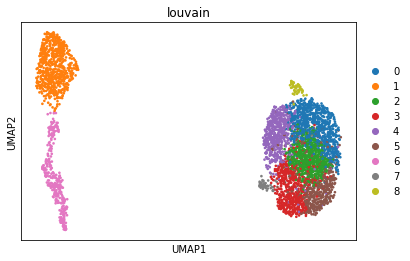

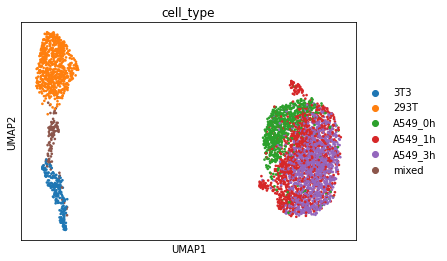

... storing 'kmeans' as categorical


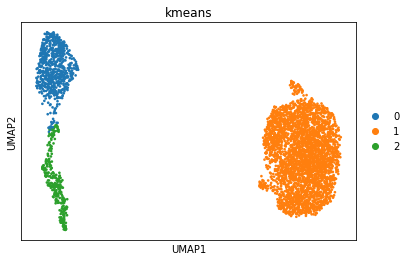

In [7]:
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=latent)
cell_embeddings = pd.read_csv(input_path+'sciCAR_cell_annot.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
prior_adata.obsm["X_multi_vi"] = latent

# louvain cluster
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

# Kmeans cluster
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_multi_vi"]

kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])
plt.show()

In [ ]:
# save all output to files
# 1. 20-diemension joint latent embedding of scMVP
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation.csv"))

# 2. 2-diemension UMAP visualization
df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=dataset.barcodes)
# add label columns
df.insert(0,"kmeans",prior_adata.obs['kmeans'].values)
df.to_csv(os.path.join(output_path,"multivae_umap.csv"))

# 3. whole scATAC imputations and scRNA imputations. It will took really long time if the scATAC dataset is very large.
df = pd.DataFrame(data=imputed_values[1].T, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=dataset.barcodes, index=dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation.csv"))

## Step3: Perform differential analysis
Here, we demostrate two DE contrasts of A549_1h/A549_0h and A549_3h/A549_0h.   
You can change the DE groups as one cell type versus all other cell types.

In [8]:
# Differential gene analysis
posterior_adata = anndata.AnnData(X=imputed_values[0])
posterior_adata.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] =  cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
sc.tl.rank_genes_groups(posterior_adata, 'cell_type', group=["A549_1h","A549_3h"],reference="A549_0h")
df_tab=sc.get.rank_genes_groups_df(posterior_adata, group=["A549_1h","A549_3h"])
df_tab.to_csv("{}/sciCAR_A549_DEG_tutorial.csv".format(output_path),index=False)

... storing 'cell_type' as categorical


## (Optional) Pre-training
- For large and complex realistic joint profiling dataset like SHARE-seq skin dataset, we recommend to perform pre-training before scMVP training.

- We next give a demo for pretraining of scRNA and scATAC, and then perform scMVP training.

### Step1: Construct separate dataset obeject

In [10]:
atac_dataset = GeneExpressionDataset()
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
atac_dataset.populate_from_data(
    X=dataset.atac_expression, # notice the normalization
    batch_indices=None,
    gene_names=dataset.atac_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=[],
)
rna_dataset = GeneExpressionDataset()
Ys = []
measurement = CellMeasurement(
        name="atac_expression",
        data=atac_dataset.X,
        columns_attr_name="atac_names",
        columns=atac_dataset.gene_names,
    )
Ys.append(measurement)
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
rna_dataset.populate_from_data(
    X=dataset.X,
    batch_indices=None,
    gene_names=dataset.gene_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=Ys,
)

[2021-08-16 08:05:43,120] WARNING - scMVP.dataset.dataset | This dataset has some empty cells, this might fail scMVP inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2021-08-16 08:05:43,132] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-16 08:05:43,134] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-16 08:05:43,197] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-16 08:05:43,198] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]


### Step2: Pretrain and visualize ATAC dataset
(approximate 1min on 1080Ti)

In [11]:
# ATAC pretraining
pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/pre_atac_trainer_tutorial.pkl' % output_path):
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_tutorial.pkl' % output_path))
    pre_atac_trainer.model.eval()
else:
    pre_atac_trainer.train(n_epochs=15, lr=lr)
    torch.save(pre_atac_trainer.model.state_dict(), '%s/pre_atac_trainer_tutorial.pkl' % output_path)
    pre_atac_trainer.model.eval()


training:   0%|          | 0/15 [00:00<?, ?it/s]reconst_loss=2223.188721, kl_divergence=0.110498
tensor(2224.1887, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2311.976562, kl_divergence=0.134964
tensor(2312.9766, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2066.347168, kl_divergence=0.180717
tensor(2067.3474, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2474.969238, kl_divergence=0.221154
tensor(2475.9695, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2170.991211, kl_divergence=0.284298
tensor(2171.9915, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1779.639160, kl_divergence=0.348201
tensor(1780.6393, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2555.392090, kl_divergence=0.421223
tensor(2556.3923, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2157.039062, kl_divergence=0.541963
tensor(2158.0391, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2427.394043, kl_divergence=0.652673
tensor(2428.3940, device='cuda:0', grad

reconst_loss=1707.448486, kl_divergence=46.611038
tensor(1708.5649, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1654.766235, kl_divergence=44.882309
tensor(1655.8785, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2010.102661, kl_divergence=44.006378
tensor(2011.2130, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1521.619141, kl_divergence=44.852646
tensor(1522.7314, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1653.627686, kl_divergence=44.600937
tensor(1654.7391, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1962.818359, kl_divergence=45.929180
tensor(1963.9333, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1666.270020, kl_divergence=47.991943
tensor(1667.3901, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2447.921631, kl_divergence=47.795040
tensor(2449.0410, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1955.586792, kl_divergence=48.299652
tensor(1956.7076, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1478.9

reconst_loss=2199.573242, kl_divergence=54.822914
tensor(2200.8472, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1880.969360, kl_divergence=56.321804
tensor(1882.2511, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1705.023682, kl_divergence=54.814716
tensor(1706.2979, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1909.063965, kl_divergence=57.137695
tensor(1910.3497, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1894.327393, kl_divergence=57.558182
tensor(1895.6154, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1801.478760, kl_divergence=56.510216
tensor(1802.7614, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1930.669434, kl_divergence=57.884148
tensor(1931.9589, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1840.254150, kl_divergence=56.914776
tensor(1841.5388, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1464.182861, kl_divergence=57.879593
tensor(1465.4723, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1913.4

reconst_loss=1660.687866, kl_divergence=55.677258
tensor(1662.1055, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1596.805908, kl_divergence=55.590561
tensor(1598.2229, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1717.761353, kl_divergence=55.606628
tensor(1719.1785, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1823.458496, kl_divergence=55.655701
tensor(1824.8760, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1369.876465, kl_divergence=55.687099
tensor(1371.2942, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1535.363525, kl_divergence=57.373268
tensor(1536.7938, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1656.600464, kl_divergence=57.071648
tensor(1658.0286, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2019.671509, kl_divergence=57.608295
tensor(2021.1039, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2055.074707, kl_divergence=56.716473
tensor(2056.4998, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2078.1

reconst_loss=1965.013550, kl_divergence=53.869141
tensor(1966.5522, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1475.870117, kl_divergence=53.102573
reconst_loss=1717.998413, kl_divergence=54.596527
reconst_loss=1704.721191, kl_divergence=53.191547
reconst_loss=1889.536133, kl_divergence=54.701996
reconst_loss=1440.564575, kl_divergence=55.252220
reconst_loss=1896.698730, kl_divergence=53.837265
reconst_loss=1870.809082, kl_divergence=54.749992
reconst_loss=1382.745117, kl_divergence=55.549801
reconst_loss=1607.625488, kl_divergence=53.990551
reconst_loss=1526.621582, kl_divergence=55.524727
reconst_loss=1466.244141, kl_divergence=54.832939
reconst_loss=1668.755249, kl_divergence=52.012146
reconst_loss=1998.295654, kl_divergence=52.752869
reconst_loss=1807.750366, kl_divergence=53.855843
reconst_loss=1768.417969, kl_divergence=54.442810
reconst_loss=1824.967407, kl_divergence=55.326614
reconst_loss=1465.062256, kl_divergence=54.987305
reconst_loss=1724.362061, kl_divergence=5

reconst_loss=1810.626465, kl_divergence=53.473106
tensor(1812.2949, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1918.953857, kl_divergence=55.383995
tensor(1920.6461, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1385.428101, kl_divergence=52.440277
tensor(1387.0837, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1731.355713, kl_divergence=51.643410
tensor(1733.0013, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2253.031250, kl_divergence=52.654961
tensor(2254.6897, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1594.750000, kl_divergence=52.251793
tensor(1596.4033, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1781.355347, kl_divergence=52.307480
tensor(1783.0093, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1715.091553, kl_divergence=52.403538
tensor(1716.7466, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1609.151367, kl_divergence=50.703934
tensor(1610.7854, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2350.1

reconst_loss=1797.850708, kl_divergence=52.577869
tensor(1799.6395, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1854.888184, kl_divergence=52.966087
tensor(1856.6829, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2353.095215, kl_divergence=54.397079
tensor(2354.9116, device='cuda:0', grad_fn=<DivBackward0>)
training:  73%|███████▎  | 11/15 [00:17<00:06,  1.66s/it]reconst_loss=1594.551025, kl_divergence=51.426643
tensor(1596.4512, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1776.252686, kl_divergence=52.240852
tensor(1778.1667, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1971.296631, kl_divergence=56.403625
tensor(1973.2838, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1483.598633, kl_divergence=53.368523
tensor(1485.5326, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1561.902222, kl_divergence=55.832573
tensor(1563.8794, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1836.579834, kl_divergence=55.863445
tensor(1838.5577, dev

reconst_loss=1709.475342, kl_divergence=56.826546
tensor(1711.6119, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1646.410889, kl_divergence=58.506580
tensor(1648.5812, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1313.779907, kl_divergence=57.753372
tensor(1315.9351, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1691.644775, kl_divergence=56.953918
tensor(1693.7839, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2056.820557, kl_divergence=59.348846
tensor(2059.0078, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1938.182617, kl_divergence=59.282242
tensor(1940.3683, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1683.567505, kl_divergence=57.401970
tensor(1685.7157, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1691.135254, kl_divergence=56.210953
tensor(1693.2595, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1872.901611, kl_divergence=59.322189
tensor(1875.0883, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1861.1

reconst_loss=1894.397461, kl_divergence=62.313221
tensor(1896.7997, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1941.945557, kl_divergence=64.625648
tensor(1944.3998, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1630.607910, kl_divergence=64.190369
tensor(1633.0524, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2038.947266, kl_divergence=65.166405
tensor(2041.4137, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1517.450439, kl_divergence=65.590446
tensor(1519.9263, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1524.201904, kl_divergence=63.160736
tensor(1526.6233, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1718.963867, kl_divergence=63.589424
tensor(1721.3949, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1555.607666, kl_divergence=62.448387
tensor(1558.0128, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1577.338379, kl_divergence=60.056133
tensor(1579.6898, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1725.3

reconst_loss=1575.913086, kl_divergence=66.608017
tensor(1578.5785, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1469.841309, kl_divergence=65.177567
tensor(1472.4707, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1677.959473, kl_divergence=65.830338
tensor(1680.6052, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1868.871338, kl_divergence=68.010941
tensor(1871.5717, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2220.422363, kl_divergence=68.883179
tensor(2223.1445, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1732.961548, kl_divergence=68.068039
tensor(1735.6635, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2048.431152, kl_divergence=68.859909
tensor(2051.1528, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1716.456543, kl_divergence=66.976913
tensor(1719.1310, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2212.566895, kl_divergence=68.331650
tensor(2215.2754, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1729.0

reconst_loss=1539.444702, kl_divergence=69.759377
tensor(1542.3632, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1802.630859, kl_divergence=68.600525
tensor(1805.5175, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1668.496094, kl_divergence=71.078003
tensor(1671.4509, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1469.620605, kl_divergence=70.947968
tensor(1472.5718, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2139.181396, kl_divergence=72.528404
tensor(2142.1758, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1809.353760, kl_divergence=72.539825
tensor(1812.3488, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1623.529297, kl_divergence=69.161720
tensor(1626.4315, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1810.858032, kl_divergence=70.765427
tensor(1813.8042, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1724.360107, kl_divergence=71.022690
tensor(1727.3136, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1324.5

reconst_loss=1665.950684, kl_divergence=79.851929
tensor(1669.3462, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1636.717773, kl_divergence=75.886826
tensor(1639.9944, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1654.102051, kl_divergence=80.072350
tensor(1657.5042, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1819.603271, kl_divergence=76.791168
tensor(1822.9070, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1606.642334, kl_divergence=76.252518
tensor(1609.9301, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1804.140869, kl_divergence=74.913246
tensor(1807.3882, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1517.259521, kl_divergence=72.299866
tensor(1520.4285, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1596.448242, kl_divergence=74.598450
tensor(1599.6863, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1457.839111, kl_divergence=74.849655
tensor(1461.0847, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1519.6

reconst_loss=1830.759766, kl_divergence=76.256004
tensor(1834.2382, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1689.480469, kl_divergence=80.071556
tensor(1693.0829, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2111.480957, kl_divergence=78.182686
tensor(2115.0222, device='cuda:0', grad_fn=<DivBackward0>)
training: 19it [00:35,  2.13s/it]reconst_loss=1399.399658, kl_divergence=79.852081
tensor(1403.1946, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1880.746460, kl_divergence=79.370094
tensor(1884.5247, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1826.729126, kl_divergence=77.947296
tensor(1830.4574, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1562.409546, kl_divergence=77.073563
tensor(1566.1073, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2055.575195, kl_divergence=80.850304
tensor(2059.4048, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1463.362427, kl_divergence=77.501678
tensor(1467.0750, device='cuda:0', grad_fn=<D

reconst_loss=1624.136963, kl_divergence=81.192703
reconst_loss=1836.325928, kl_divergence=79.045090
reconst_loss=1586.905518, kl_divergence=79.444641
reconst_loss=1627.494629, kl_divergence=75.327858
reconst_loss=1766.577637, kl_divergence=80.595673
reconst_loss=1483.359741, kl_divergence=77.132690
reconst_loss=1760.590454, kl_divergence=77.099541
reconst_loss=1596.156250, kl_divergence=79.762634
reconst_loss=1593.855225, kl_divergence=77.765350
reconst_loss=1829.049072, kl_divergence=82.145027
reconst_loss=1506.985107, kl_divergence=81.428749
reconst_loss=1893.601929, kl_divergence=78.571106
reconst_loss=1703.684082, kl_divergence=78.387024
reconst_loss=1662.187134, kl_divergence=78.980347
reconst_loss=1322.061279, kl_divergence=80.139099
reconst_loss=1604.042725, kl_divergence=78.873779
reconst_loss=1479.592896, kl_divergence=82.274780
reconst_loss=1749.137695, kl_divergence=78.508255
reconst_loss=1718.764160, kl_divergence=82.319626
reconst_loss=1554.902344, kl_divergence=80.315033


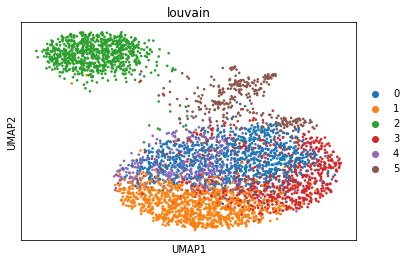

In [13]:
# ATAC pretrainer_posterior:
full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

### Step3: Perform similar pretraining for scRNA dataset
(less than 1min)

training:   0%|          | 0/10 [00:00<?, ?it/s]reconst_loss=3372.981445, kl_divergence=0.790359
tensor(3373.9817, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3184.722168, kl_divergence=1.100110
tensor(3185.7224, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3086.594238, kl_divergence=1.290236
tensor(3087.5945, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3130.473877, kl_divergence=1.682800
tensor(3131.4741, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3069.042969, kl_divergence=2.134964
tensor(3070.0432, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2891.648438, kl_divergence=2.135544
tensor(2892.6487, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3107.014160, kl_divergence=2.680740
tensor(3108.0144, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3061.668945, kl_divergence=3.302228
tensor(3062.6689, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2909.187500, kl_divergence=3.099576
tensor(2910.1875, device='cuda:0', grad

reconst_loss=1954.188965, kl_divergence=62.220146
tensor(1955.3445, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1930.132812, kl_divergence=60.741207
tensor(1931.2845, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1961.032227, kl_divergence=61.947437
tensor(1962.1871, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2026.489258, kl_divergence=62.903450
tensor(2027.6466, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2051.863770, kl_divergence=67.953804
tensor(2053.0339, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1951.066162, kl_divergence=61.476349
tensor(1952.2201, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1969.893677, kl_divergence=65.440857
tensor(1971.0575, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1835.289429, kl_divergence=59.366268
tensor(1836.4379, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2029.097168, kl_divergence=64.190231
tensor(2030.2578, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1991.2

reconst_loss=1907.377808, kl_divergence=75.566910
tensor(1908.7557, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1942.918335, kl_divergence=70.248192
tensor(1944.2697, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1927.584473, kl_divergence=74.043121
tensor(1928.9550, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1884.495361, kl_divergence=79.528061
tensor(1885.8931, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1914.042725, kl_divergence=73.952957
tensor(1915.4126, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1923.874268, kl_divergence=76.636398
tensor(1925.2574, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1943.860107, kl_divergence=76.469582
tensor(1945.2426, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1927.289551, kl_divergence=76.767014
tensor(1928.6735, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1928.003662, kl_divergence=76.299225
tensor(1929.3854, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1884.3

reconst_loss=1936.598267, kl_divergence=83.893158
tensor(1938.2275, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1985.835815, kl_divergence=84.343948
tensor(1987.4684, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1835.745117, kl_divergence=80.714325
tensor(1837.3503, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1880.984619, kl_divergence=78.156349
tensor(1882.5709, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1889.519409, kl_divergence=86.716125
tensor(1891.1699, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1851.740112, kl_divergence=79.192589
tensor(1853.3341, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1929.631348, kl_divergence=81.522659
tensor(1931.2428, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1834.328735, kl_divergence=73.688431
tensor(1835.8813, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1895.538574, kl_divergence=77.195862
tensor(1897.1176, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1913.3

reconst_loss=1835.452026, kl_divergence=82.665359
reconst_loss=1851.833618, kl_divergence=81.216599
reconst_loss=1839.206787, kl_divergence=83.229630
reconst_loss=1895.560059, kl_divergence=79.700821
reconst_loss=1979.949951, kl_divergence=87.389267
reconst_loss=1824.022461, kl_divergence=82.863564
reconst_loss=1858.940063, kl_divergence=84.180603
reconst_loss=1885.194580, kl_divergence=81.074982
reconst_loss=1888.960938, kl_divergence=85.410553
reconst_loss=1912.489380, kl_divergence=84.423866
reconst_loss=1816.429077, kl_divergence=81.253990
reconst_loss=1871.474365, kl_divergence=80.409409
reconst_loss=1881.856689, kl_divergence=82.902847
reconst_loss=1844.593750, kl_divergence=78.277451
reconst_loss=1833.208740, kl_divergence=80.184334
reconst_loss=1830.648193, kl_divergence=79.106720
reconst_loss=1840.830078, kl_divergence=76.825211
reconst_loss=1842.383545, kl_divergence=78.745438
reconst_loss=1855.881958, kl_divergence=78.327858
reconst_loss=1845.258423, kl_divergence=78.831833


reconst_loss=1859.095581, kl_divergence=86.116821
tensor(1861.1721, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1837.889648, kl_divergence=85.117233
tensor(1839.9539, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1899.310425, kl_divergence=84.163628
tensor(1901.3623, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1855.862549, kl_divergence=83.145294
tensor(1857.9020, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1839.737793, kl_divergence=82.312790
tensor(1841.7668, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1847.575073, kl_divergence=85.582108
tensor(1849.6449, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1836.557129, kl_divergence=84.555786
tensor(1838.6141, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1863.626587, kl_divergence=84.084846
tensor(1865.6779, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1943.423950, kl_divergence=85.537628
tensor(1945.4933, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1819.9

reconst_loss=1833.487671, kl_divergence=85.465439
tensor(1835.9834, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1878.466919, kl_divergence=87.666245
tensor(1881.0012, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1875.264160, kl_divergence=83.187866
tensor(1877.7201, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1793.032715, kl_divergence=86.868896
tensor(1795.5531, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1812.285889, kl_divergence=88.686005
tensor(1814.8380, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1886.812378, kl_divergence=87.603615
tensor(1889.3456, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1825.858643, kl_divergence=89.490814
tensor(1828.4249, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1857.789307, kl_divergence=82.656128
tensor(1860.2358, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1802.331177, kl_divergence=87.578819
tensor(1804.8639, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1816.4

reconst_loss=1868.570557, kl_divergence=93.099869
tensor(1871.4327, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1801.135742, kl_divergence=84.309509
tensor(1803.8220, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1832.829712, kl_divergence=88.260445
tensor(1835.5951, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1744.226318, kl_divergence=89.139565
tensor(1747.0090, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1766.364990, kl_divergence=89.459816
tensor(1769.1542, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1823.140381, kl_divergence=91.701180
tensor(1825.9745, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1909.397949, kl_divergence=89.441833
tensor(1912.1869, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1874.475342, kl_divergence=89.827705
tensor(1877.2721, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1879.337158, kl_divergence=89.204102
tensor(1882.1213, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1843.5

reconst_loss=1802.955566, kl_divergence=88.999435
tensor(1805.9581, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1882.362915, kl_divergence=93.245148
tensor(1885.4611, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1795.782715, kl_divergence=91.848663
tensor(1798.8495, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1826.517578, kl_divergence=91.579773
tensor(1829.5782, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1785.564941, kl_divergence=93.205276
tensor(1788.6621, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1816.371582, kl_divergence=88.942291
tensor(1819.3729, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1858.307617, kl_divergence=89.975563
tensor(1861.3320, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1784.557617, kl_divergence=86.527542
tensor(1787.5048, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1851.269287, kl_divergence=88.610397
tensor(1854.2632, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1825.1

reconst_loss=1822.527954, kl_divergence=91.038879
reconst_loss=1823.949951, kl_divergence=83.597412
reconst_loss=1800.202148, kl_divergence=86.984604
reconst_loss=1808.983643, kl_divergence=87.243927
reconst_loss=1778.098633, kl_divergence=85.336716
reconst_loss=1858.109741, kl_divergence=89.841415
reconst_loss=1755.748657, kl_divergence=86.495712
reconst_loss=1745.612061, kl_divergence=85.354324
reconst_loss=1780.412354, kl_divergence=89.643959
reconst_loss=1751.195679, kl_divergence=86.529625
reconst_loss=1737.060547, kl_divergence=85.325104
reconst_loss=1742.577637, kl_divergence=87.557243
reconst_loss=1825.914795, kl_divergence=91.740837
reconst_loss=1845.267090, kl_divergence=91.299377
reconst_loss=1833.480469, kl_divergence=86.113480
reconst_loss=1766.319092, kl_divergence=86.493462
reconst_loss=1809.189331, kl_divergence=87.480949
reconst_loss=1779.724487, kl_divergence=85.209412
reconst_loss=1744.690186, kl_divergence=86.667664
reconst_loss=1769.731201, kl_divergence=88.435425


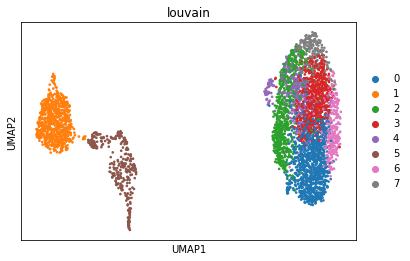

In [15]:
# RNA embedding
pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=True,
    frequency=5,
)


if os.path.isfile('%s/pre_trainer_tutorial.pkl' % output_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_tutorial.pkl' % output_path))
    pre_trainer.model.eval()

else:
    pre_trainer.train(n_epochs=10, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer_tutorial.pkl' % output_path)
    pre_trainer.model.eval()


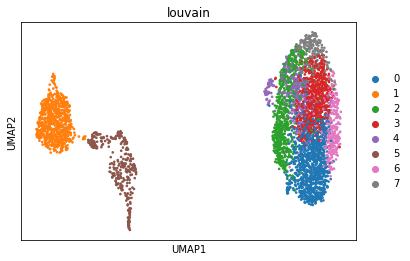

In [16]:
# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

### Step4:  Perform scMVP training with two pretrained models
(few minutes)

In [17]:
# get n_centroids from scRNA data
n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))


multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/multi_vae_trainer_tutorial2.pkl' % output_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_trainer_tutorial2.pkl' % output_path))
    trainer.model.eval()
else:
    pre_trainer = UnsupervisedTrainer(
        pre_vae,
        rna_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_tutorial.pkl' % output_path))

    pre_atac_trainer = UnsupervisedTrainer(
        pre_atac_vae,
        atac_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_tutorial.pkl' % output_path))

    n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

    # joint RNA and ATAC embedding
    trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

    trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
    for param in trainer.model.RNA_encoder.parameters():
        param.requires_grad = True
    trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
    for param in trainer.model.ATAC_encoder.parameters():
        param.requires_grad = True
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_tutorial2.pkl' % output_path)
    trainer.model.eval()

training:   0%|          | 0/15 [00:00<?, ?it/s]logpzc:-205.41561889648438, logqcx:-2.079441547393799
kld_qz_pz = 165.758743,kld_qz_rna = 18467.853516,kld_qz_atac = 4801.834961,kl_divergence = 17417.916016,reconst_loss_rna = 9533.786133,        reconst_loss_atac = 222.985657, mu=0.388228, sigma=0.878287
reconst_loss = 9807.140625,kl_divergence_local = 17417.916016,kl_weight = 1.000000,loss = 27225.054688
tensor(27225.0547, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-1207.67236328125, logqcx:-2.079441547393799
kld_qz_pz = 1166.077271,kld_qz_rna = 21609.318359,kld_qz_atac = 5748.049805,kl_divergence = 1203.720337,reconst_loss_rna = 9793.573242,        reconst_loss_atac = 213.483292, mu=0.388117, sigma=0.879255
reconst_loss = 10057.423828,kl_divergence_local = 1203.720337,kl_weight = 1.000000,loss = 11261.144531
tensor(11261.1445, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-278.04437255859375, logqcx:-2.079441547393799
kld_qz_pz = 236.838409,kld_qz_rna = 21058.574219,kld_qz_atac

kld_qz_pz = 70.177597,kld_qz_rna = 12544.181641,kld_qz_atac = 16364.601562,kl_divergence = 76.226173,reconst_loss_rna = 9198.335938,        reconst_loss_atac = 189.197983, mu=0.387153, sigma=0.895928
reconst_loss = 9437.900391,kl_divergence_local = 76.226173,kl_weight = 1.000000,loss = 9514.126953
tensor(9514.1270, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-107.13423919677734, logqcx:-2.079441547393799
kld_qz_pz = 69.087471,kld_qz_rna = 12663.124023,kld_qz_atac = 26767.589844,kl_divergence = 75.777664,reconst_loss_rna = 9273.754883,        reconst_loss_atac = 217.987579, mu=0.387138, sigma=0.896727
reconst_loss = 9542.110352,kl_divergence_local = 75.777664,kl_weight = 1.000000,loss = 9617.887695
tensor(9617.8877, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-106.38597106933594, logqcx:-2.079441547393799
kld_qz_pz = 68.495148,kld_qz_rna = 12925.347656,kld_qz_atac = 48587.375000,kl_divergence = 74.024445,reconst_loss_rna = 9613.800781,        reconst_loss_atac = 226.155579, mu=0

logpzc:-92.0701904296875, logqcx:-2.079441547393799
kld_qz_pz = 56.935268,kld_qz_rna = 14788.894531,kld_qz_atac = 36275.851562,kl_divergence = 60.826660,reconst_loss_rna = 8961.777344,        reconst_loss_atac = 186.064590, mu=0.386971, sigma=0.911728
reconst_loss = 9198.209961,kl_divergence_local = 60.826660,kl_weight = 1.000000,loss = 9259.037109
tensor(9259.0371, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-91.87928771972656, logqcx:-2.079441547393799
kld_qz_pz = 56.876446,kld_qz_rna = 9528.425781,kld_qz_atac = 38815.605469,kl_divergence = 60.256756,reconst_loss_rna = 8803.953125,        reconst_loss_atac = 191.575073, mu=0.386964, sigma=0.912375
reconst_loss = 9045.895508,kl_divergence_local = 60.256756,kl_weight = 1.000000,loss = 9106.152344
tensor(9106.1523, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-90.72386169433594, logqcx:-2.079441547393799
kld_qz_pz = 55.768913,kld_qz_rna = 13390.034180,kld_qz_atac = 34570.406250,kl_divergence = 59.546558,reconst_loss_rna = 8675.47

logpzc:-89.64826202392578, logqcx:-2.079441547393799
kld_qz_pz = 55.751053,kld_qz_rna = 11065.862305,kld_qz_atac = 55434.156250,kl_divergence = 59.466843,reconst_loss_rna = 8540.544922,        reconst_loss_atac = 245.880524, mu=0.386935, sigma=0.924160
reconst_loss = 8836.792969,kl_divergence_local = 59.466843,kl_weight = 1.000000,loss = 8896.259766
tensor(8896.2598, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-89.38652801513672, logqcx:-2.079441547393799
kld_qz_pz = 55.551025,kld_qz_rna = 10402.851562,kld_qz_atac = 44974.296875,kl_divergence = 59.236073,reconst_loss_rna = 8102.687500,        reconst_loss_atac = 188.975647, mu=0.386945, sigma=0.924766
reconst_loss = 8342.031250,kl_divergence_local = 59.236073,kl_weight = 1.000000,loss = 8401.267578
tensor(8401.2676, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-90.36671447753906, logqcx:-2.079441547393799
kld_qz_pz = 56.532539,kld_qz_rna = 13165.699219,kld_qz_atac = 45696.187500,kl_divergence = 60.353294,reconst_loss_rna = 8563.

logpzc:-87.51155090332031, logqcx:-2.079441547393799
kld_qz_pz = 53.627148,kld_qz_rna = 10655.710938,kld_qz_atac = 54314.859375,kl_divergence = 57.124798,reconst_loss_rna = 7176.609375,        reconst_loss_atac = 249.579605, mu=0.387311, sigma=0.936209
reconst_loss = 7476.557129,kl_divergence_local = 57.124798,kl_weight = 1.000000,loss = 7533.681641
tensor(7533.6816, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-87.5015869140625, logqcx:-2.079441547393799
kld_qz_pz = 53.667248,kld_qz_rna = 10641.775391,kld_qz_atac = 54174.625000,kl_divergence = 57.303604,reconst_loss_rna = 7055.211914,        reconst_loss_atac = 214.704224, mu=0.387334, sigma=0.936812
reconst_loss = 7320.284180,kl_divergence_local = 57.303604,kl_weight = 1.000000,loss = 7377.587891
tensor(7377.5879, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-87.46128845214844, logqcx:-2.079441547393799
kld_qz_pz = 53.651314,kld_qz_rna = 11527.279297,kld_qz_atac = 48185.585938,kl_divergence = 57.271080,reconst_loss_rna = 7206.9

logpzc:-88.00582885742188, logqcx:-2.079441547393799
kld_qz_pz = 53.972511,kld_qz_rna = 7760.192383,kld_qz_atac = 48626.929688,kl_divergence = 57.155369,reconst_loss_rna = 6635.733398,        reconst_loss_atac = 221.624908, mu=0.387484, sigma=0.948465
reconst_loss = 6907.726562,kl_divergence_local = 57.155369,kl_weight = 1.000000,loss = 6964.881836
tensor(6964.8818, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-86.9658203125, logqcx:-2.079441547393799
kld_qz_pz = 52.916302,kld_qz_rna = 8941.935547,kld_qz_atac = 69666.492188,kl_divergence = 56.103584,reconst_loss_rna = 6486.252441,        reconst_loss_atac = 209.605957, mu=0.387470, sigma=0.949093
reconst_loss = 6746.226562,kl_divergence_local = 56.103584,kl_weight = 1.000000,loss = 6802.330078
tensor(6802.3301, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-89.12614440917969, logqcx:-2.079441547393799
kld_qz_pz = 55.097870,kld_qz_rna = 10557.377930,kld_qz_atac = 40273.453125,kl_divergence = 58.163887,reconst_loss_rna = 7002.667969

training:  27%|██▋       | 4/15 [00:12<00:34,  3.15s/it]logpzc:-87.16472625732422, logqcx:-2.079441547393799
kld_qz_pz = 53.239948,kld_qz_rna = 8928.054688,kld_qz_atac = 48989.445312,kl_divergence = 56.387348,reconst_loss_rna = 6165.444824,        reconst_loss_atac = 237.329285, mu=0.386966, sigma=0.961179
reconst_loss = 6453.142578,kl_divergence_local = 56.387348,kl_weight = 1.000000,loss = 6509.529785
tensor(6509.5298, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-88.34231567382812, logqcx:-2.079441547393799
kld_qz_pz = 54.424561,kld_qz_rna = 9513.327148,kld_qz_atac = 47409.871094,kl_divergence = 57.584656,reconst_loss_rna = 6295.879395,        reconst_loss_atac = 196.730499, mu=0.386934, sigma=0.961822
reconst_loss = 6542.977539,kl_divergence_local = 57.584656,kl_weight = 1.000000,loss = 6600.562500
tensor(6600.5625, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-89.1456069946289, logqcx:-2.079441547393799
kld_qz_pz = 55.261322,kld_qz_rna = 9770.945312,kld_qz_atac = 45283.96875

kld_qz_pz = 53.822792,kld_qz_rna = 8413.259766,kld_qz_atac = 71559.984375,kl_divergence = 56.918335,reconst_loss_rna = 6068.250000,        reconst_loss_atac = 249.655334, mu=0.386222, sigma=0.974188
reconst_loss = 6368.273438,kl_divergence_local = 56.918335,kl_weight = 1.000000,loss = 6425.191895
tensor(6425.1919, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-88.02054595947266, logqcx:-2.079441547393799
kld_qz_pz = 54.734074,kld_qz_rna = 10250.678711,kld_qz_atac = 48625.539062,kl_divergence = 57.841537,reconst_loss_rna = 6250.063477,        reconst_loss_atac = 171.268478, mu=0.386182, sigma=0.974838
reconst_loss = 6471.700195,kl_divergence_local = 57.841537,kl_weight = 1.000000,loss = 6529.541016
tensor(6529.5410, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-87.40351104736328, logqcx:-2.079441547393799
kld_qz_pz = 54.029633,kld_qz_rna = 8073.117676,kld_qz_atac = 45550.722656,kl_divergence = 57.119377,reconst_loss_rna = 6353.719727,        reconst_loss_atac = 199.440979, mu=0.386

kld_qz_pz = 53.362633,kld_qz_rna = 8531.403320,kld_qz_atac = 28497.417969,kl_divergence = 56.469513,reconst_loss_rna = 6103.750977,        reconst_loss_atac = 198.394882, mu=0.385420, sigma=0.987144
reconst_loss = 6352.513672,kl_divergence_local = 56.469513,kl_weight = 1.000000,loss = 6408.983398
tensor(6408.9834, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-86.83592224121094, logqcx:-2.079441547393799
kld_qz_pz = 53.991577,kld_qz_rna = 9482.571289,kld_qz_atac = 55040.226562,kl_divergence = 57.067032,reconst_loss_rna = 6134.047363,        reconst_loss_atac = 206.604279, mu=0.385383, sigma=0.987783
reconst_loss = 6391.020020,kl_divergence_local = 57.067032,kl_weight = 1.000000,loss = 6448.086914
tensor(6448.0869, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-86.72301483154297, logqcx:-2.079441547393799
kld_qz_pz = 53.898567,kld_qz_rna = 9198.408203,kld_qz_atac = 63395.718750,kl_divergence = 57.009926,reconst_loss_rna = 6203.484863,        reconst_loss_atac = 235.315155, mu=0.3853

kld_qz_pz = 52.380123,kld_qz_rna = 8211.700195,kld_qz_atac = 70738.500000,kl_divergence = 55.545479,reconst_loss_rna = 6055.112305,        reconst_loss_atac = 233.382889, mu=0.384724, sigma=0.999683
reconst_loss = 6338.863281,kl_divergence_local = 55.545479,kl_weight = 1.000000,loss = 6394.408691
tensor(6394.4087, device='cuda:0', grad_fn=<DivBackward0>)
training:  33%|███▎      | 5/15 [00:18<00:40,  4.06s/it]logpzc:-82.25076293945312, logqcx:-2.079441547393799
kld_qz_pz = 49.941620,kld_qz_rna = 7124.622070,kld_qz_atac = 29228.703125,kl_divergence = 53.060081,reconst_loss_rna = 5845.207520,        reconst_loss_atac = 214.586029, mu=0.384685, sigma=1.000305
reconst_loss = 6110.161621,kl_divergence_local = 53.060081,kl_weight = 1.000000,loss = 6163.221680
tensor(6163.2217, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-83.86873626708984, logqcx:-2.079441547393799
kld_qz_pz = 51.515015,kld_qz_rna = 7219.691406,kld_qz_atac = 64560.765625,kl_divergence = 54.711304,reconst_loss_rna = 5961.

kld_qz_pz = 48.820789,kld_qz_rna = 6724.619141,kld_qz_atac = 44501.957031,kl_divergence = 52.079819,reconst_loss_rna = 5907.673340,        reconst_loss_atac = 232.801025, mu=0.384004, sigma=1.011775
reconst_loss = 6190.842773,kl_divergence_local = 52.079819,kl_weight = 1.000000,loss = 6242.922363
tensor(6242.9224, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-81.58723449707031, logqcx:-2.079441547393799
kld_qz_pz = 49.454987,kld_qz_rna = 7601.856445,kld_qz_atac = 48107.367188,kl_divergence = 52.749725,reconst_loss_rna = 6080.266602,        reconst_loss_atac = 207.932083, mu=0.383973, sigma=1.012363
reconst_loss = 6338.566406,kl_divergence_local = 52.749725,kl_weight = 1.000000,loss = 6391.316406
tensor(6391.3164, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-80.08460998535156, logqcx:-2.079441547393799
kld_qz_pz = 47.992817,kld_qz_rna = 7103.224609,kld_qz_atac = 27572.621094,kl_divergence = 50.982841,reconst_loss_rna = 6035.321777,        reconst_loss_atac = 243.144043, mu=0.3839

kld_qz_pz = 47.927101,kld_qz_rna = 7749.447266,kld_qz_atac = 52748.851562,kl_divergence = 51.053612,reconst_loss_rna = 6000.589844,        reconst_loss_atac = 207.802002, mu=0.383376, sigma=1.023440
reconst_loss = 6258.759766,kl_divergence_local = 51.053612,kl_weight = 1.000000,loss = 6309.813477
tensor(6309.8135, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-77.90641021728516, logqcx:-2.079441547393799
kld_qz_pz = 46.024227,kld_qz_rna = 6474.679688,kld_qz_atac = 45261.027344,kl_divergence = 49.129555,reconst_loss_rna = 5935.421875,        reconst_loss_atac = 235.487427, mu=0.383352, sigma=1.024011
reconst_loss = 6221.277344,kl_divergence_local = 49.129555,kl_weight = 1.000000,loss = 6270.406738
tensor(6270.4067, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-77.3872299194336, logqcx:-2.079441547393799
kld_qz_pz = 45.543755,kld_qz_rna = 6211.585938,kld_qz_atac = 41716.980469,kl_divergence = 48.829720,reconst_loss_rna = 5902.609375,        reconst_loss_atac = 225.919052, mu=0.38332

logpzc:-76.62126159667969, logqcx:-2.079441547393799
kld_qz_pz = 44.952957,kld_qz_rna = 7756.879395,kld_qz_atac = 28231.617188,kl_divergence = 48.167847,reconst_loss_rna = 6128.763184,        reconst_loss_atac = 214.673584, mu=0.382923, sigma=1.035105
reconst_loss = 6393.804199,kl_divergence_local = 48.167847,kl_weight = 1.000000,loss = 6441.972656
tensor(6441.9727, device='cuda:0', grad_fn=<DivBackward0>)
training:  47%|████▋     | 7/15 [00:25<00:29,  3.72s/it]logpzc:-75.65516662597656, logqcx:-2.079441547393799
kld_qz_pz = 43.979706,kld_qz_rna = 6747.469727,kld_qz_atac = 40939.410156,kl_divergence = 47.243431,reconst_loss_rna = 5932.869141,        reconst_loss_atac = 256.091553, mu=0.382904, sigma=1.035646
reconst_loss = 6239.328613,kl_divergence_local = 47.243431,kl_weight = 1.000000,loss = 6286.572266
tensor(6286.5723, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-74.62369537353516, logqcx:-2.079441547393799
kld_qz_pz = 42.957664,kld_qz_rna = 6191.279785,kld_qz_atac = 63309.6953

logpzc:-69.69990539550781, logqcx:-2.079441547393799
kld_qz_pz = 38.239182,kld_qz_rna = 5604.880371,kld_qz_atac = 25698.128906,kl_divergence = 41.405350,reconst_loss_rna = 6022.595703,        reconst_loss_atac = 201.111023, mu=0.382628, sigma=1.045712
reconst_loss = 6274.074219,kl_divergence_local = 41.405350,kl_weight = 1.000000,loss = 6315.479980
tensor(6315.4800, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-73.7032470703125, logqcx:-2.079441547393799
kld_qz_pz = 42.226578,kld_qz_rna = 6527.191406,kld_qz_atac = 27436.609375,kl_divergence = 45.388519,reconst_loss_rna = 5850.958008,        reconst_loss_atac = 190.216675, mu=0.382620, sigma=1.046227
reconst_loss = 6091.542969,kl_divergence_local = 45.388519,kl_weight = 1.000000,loss = 6136.931641
tensor(6136.9316, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-71.06771087646484, logqcx:-2.079441547393799
kld_qz_pz = 39.586971,kld_qz_rna = 6385.496094,kld_qz_atac = 28901.980469,kl_divergence = 42.678635,reconst_loss_rna = 5868.0834

logpzc:-71.22181701660156, logqcx:-2.079441547393799
kld_qz_pz = 39.866226,kld_qz_rna = 6680.598633,kld_qz_atac = 50073.289062,kl_divergence = 43.148125,reconst_loss_rna = 5454.737305,        reconst_loss_atac = 247.468628, mu=0.382462, sigma=1.056511
reconst_loss = 5752.574219,kl_divergence_local = 43.148125,kl_weight = 1.000000,loss = 5795.722656
tensor(5795.7227, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-71.38106536865234, logqcx:-2.079441547393799
kld_qz_pz = 40.020382,kld_qz_rna = 5862.802734,kld_qz_atac = 33743.847656,kl_divergence = 43.385818,reconst_loss_rna = 5773.370117,        reconst_loss_atac = 199.734131, mu=0.382455, sigma=1.057016
reconst_loss = 6023.472656,kl_divergence_local = 43.385818,kl_weight = 1.000000,loss = 6066.858398
tensor(6066.8584, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-71.93861389160156, logqcx:-2.079441547393799
kld_qz_pz = 40.629639,kld_qz_rna = 6089.223633,kld_qz_atac = 34560.132812,kl_divergence = 43.836136,reconst_loss_rna = 5983.930

logpzc:-69.72810363769531, logqcx:-2.079441547393799
kld_qz_pz = 38.528816,kld_qz_rna = 6472.200684,kld_qz_atac = 74090.164062,kl_divergence = 41.736561,reconst_loss_rna = 5807.817871,        reconst_loss_atac = 224.998520, mu=0.382414, sigma=1.066419
reconst_loss = 6083.185059,kl_divergence_local = 41.736561,kl_weight = 1.000000,loss = 6124.920410
tensor(6124.9204, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-69.49077606201172, logqcx:-2.079441547393799
kld_qz_pz = 38.414368,kld_qz_rna = 10680.051758,kld_qz_atac = 95841.171875,kl_divergence = 42.161671,reconst_loss_rna = 5810.315918,        reconst_loss_atac = 175.210022, mu=0.382410, sigma=1.066910
logpzc:-69.68120574951172, logqcx:-2.079441547393799
kld_qz_pz = 38.596088,kld_qz_rna = 11171.412109,kld_qz_atac = 106615.671875,kl_divergence = 42.254364,reconst_loss_rna = 5839.485352,        reconst_loss_atac = 210.806976, mu=0.382410, sigma=1.066910
logpzc:-69.39434051513672, logqcx:-2.079441547393799
kld_qz_pz = 38.270775,kld_qz_r

logpzc:-69.98089599609375, logqcx:-2.079441547393799
kld_qz_pz = 38.856472,kld_qz_rna = 9151.402344,kld_qz_atac = 188298.718750,kl_divergence = 42.374084,reconst_loss_rna = 6069.267578,        reconst_loss_atac = 195.601929, mu=0.382410, sigma=1.066910
logpzc:-68.95298767089844, logqcx:-2.079441547393799
kld_qz_pz = 37.893333,kld_qz_rna = 10539.689453,kld_qz_atac = 81328.234375,kl_divergence = 41.718132,reconst_loss_rna = 5795.259766,        reconst_loss_atac = 196.551270, mu=0.382410, sigma=1.066910
logpzc:-68.81686401367188, logqcx:-2.079441547393799
kld_qz_pz = 37.729233,kld_qz_rna = 11681.931641,kld_qz_atac = 122520.257812,kl_divergence = 41.418358,reconst_loss_rna = 5583.655273,        reconst_loss_atac = 202.852142, mu=0.382410, sigma=1.066910
logpzc:-69.31324768066406, logqcx:-2.079441547393799
kld_qz_pz = 38.245728,kld_qz_rna = 10953.837891,kld_qz_atac = 73540.140625,kl_divergence = 41.820381,reconst_loss_rna = 5737.495117,        reconst_loss_atac = 194.788132, mu=0.382410, si

logpzc:-70.59746551513672, logqcx:-2.079441547393799
kld_qz_pz = 39.483513,kld_qz_rna = 11799.867188,kld_qz_atac = 115743.343750,kl_divergence = 43.250565,reconst_loss_rna = 5773.611816,        reconst_loss_atac = 202.238251, mu=0.382410, sigma=1.066910
logpzc:-70.93614196777344, logqcx:-2.079441547393799
kld_qz_pz = 39.783760,kld_qz_rna = 11533.827148,kld_qz_atac = 197840.656250,kl_divergence = 43.311783,reconst_loss_rna = 5710.172852,        reconst_loss_atac = 211.089920, mu=0.382410, sigma=1.066910
logpzc:-71.32350158691406, logqcx:-2.079441547393799
kld_qz_pz = 40.249271,kld_qz_rna = 11755.054688,kld_qz_atac = 193215.937500,kl_divergence = 44.344311,reconst_loss_rna = 6099.552734,        reconst_loss_atac = 150.958679, mu=0.382410, sigma=1.066910
training:  53%|█████▎    | 8/15 [00:33<00:33,  4.85s/it]logpzc:-71.43855285644531, logqcx:-2.079441547393799
kld_qz_pz = 40.170582,kld_qz_rna = 7198.365234,kld_qz_atac = 35989.589844,kl_divergence = 43.251495,reconst_loss_rna = 6004.38183

logpzc:-68.1993408203125, logqcx:-2.079441547393799
kld_qz_pz = 37.051163,kld_qz_rna = 5638.552734,kld_qz_atac = 48034.949219,kl_divergence = 40.193039,reconst_loss_rna = 5855.976074,        reconst_loss_atac = 161.296494, mu=0.382383, sigma=1.075511
reconst_loss = 6067.640625,kl_divergence_local = 40.193039,kl_weight = 1.000000,loss = 6107.833008
tensor(6107.8330, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-68.511962890625, logqcx:-2.079441547393799
kld_qz_pz = 37.330616,kld_qz_rna = 5589.765137,kld_qz_atac = 49715.007812,kl_divergence = 40.470848,reconst_loss_rna = 5847.023438,        reconst_loss_atac = 165.164581, mu=0.382382, sigma=1.075979
reconst_loss = 6062.555664,kl_divergence_local = 40.470848,kl_weight = 1.000000,loss = 6103.026367
tensor(6103.0264, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-68.8997802734375, logqcx:-2.079441547393799
kld_qz_pz = 37.743240,kld_qz_rna = 5876.467773,kld_qz_atac = 35137.085938,kl_divergence = 40.894070,reconst_loss_rna = 5971.984375,

logpzc:-65.50714111328125, logqcx:-2.079441547393799
kld_qz_pz = 34.479256,kld_qz_rna = 5419.570312,kld_qz_atac = 57061.335938,kl_divergence = 37.729668,reconst_loss_rna = 5833.264160,        reconst_loss_atac = 191.886734, mu=0.382419, sigma=1.084648
reconst_loss = 6075.519531,kl_divergence_local = 37.729668,kl_weight = 1.000000,loss = 6113.248535
tensor(6113.2485, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-67.17095184326172, logqcx:-2.079441547393799
kld_qz_pz = 36.160732,kld_qz_rna = 7280.219727,kld_qz_atac = 29012.224609,kl_divergence = 39.390663,reconst_loss_rna = 5820.153320,        reconst_loss_atac = 162.277939, mu=0.382428, sigma=1.085090
reconst_loss = 6032.799316,kl_divergence_local = 39.390663,kl_weight = 1.000000,loss = 6072.189941
tensor(6072.1899, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-64.02836608886719, logqcx:-2.079441547393799
kld_qz_pz = 33.068470,kld_qz_rna = 5861.074219,kld_qz_atac = 37778.800781,kl_divergence = 36.329800,reconst_loss_rna = 5648.838

logpzc:-65.67306518554688, logqcx:-2.079441547393799
kld_qz_pz = 34.778542,kld_qz_rna = 6322.638672,kld_qz_atac = 61469.445312,kl_divergence = 37.993454,reconst_loss_rna = 5683.918945,        reconst_loss_atac = 173.152313, mu=0.382736, sigma=1.094003
reconst_loss = 5907.439453,kl_divergence_local = 37.993454,kl_weight = 1.000000,loss = 5945.433105
tensor(5945.4331, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-63.56192398071289, logqcx:-2.079441547393799
kld_qz_pz = 32.689228,kld_qz_rna = 5266.288574,kld_qz_atac = 25981.955078,kl_divergence = 35.883339,reconst_loss_rna = 5735.511719,        reconst_loss_atac = 234.098602, mu=0.382758, sigma=1.094452
reconst_loss = 6019.979004,kl_divergence_local = 35.883339,kl_weight = 1.000000,loss = 6055.862305
tensor(6055.8623, device='cuda:0', grad_fn=<DivBackward0>)
training:  60%|██████    | 9/15 [00:40<00:31,  5.25s/it]logpzc:-64.81057739257812, logqcx:-2.079441547393799
kld_qz_pz = 33.882076,kld_qz_rna = 5892.124512,kld_qz_atac = 32772.8085

logpzc:-62.17026138305664, logqcx:-2.079441547393799
kld_qz_pz = 31.383812,kld_qz_rna = 4902.041016,kld_qz_atac = 26462.296875,kl_divergence = 34.625679,reconst_loss_rna = 5903.010254,        reconst_loss_atac = 183.899475, mu=0.383254, sigma=1.102704
reconst_loss = 6137.277344,kl_divergence_local = 34.625679,kl_weight = 1.000000,loss = 6171.903320
tensor(6171.9033, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-63.57195281982422, logqcx:-2.079441547393799
kld_qz_pz = 32.711349,kld_qz_rna = 5381.214844,kld_qz_atac = 28518.703125,kl_divergence = 36.055496,reconst_loss_rna = 5911.468262,        reconst_loss_atac = 215.497223, mu=0.383275, sigma=1.103127
reconst_loss = 6177.333496,kl_divergence_local = 36.055496,kl_weight = 1.000000,loss = 6213.388672
tensor(6213.3887, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-61.27153778076172, logqcx:-2.079441547393799
kld_qz_pz = 30.404869,kld_qz_rna = 5081.708984,kld_qz_atac = 42763.015625,kl_divergence = 33.650459,reconst_loss_rna = 5809.113

logpzc:-60.26202392578125, logqcx:-2.079441547393799
kld_qz_pz = 29.496424,kld_qz_rna = 5002.210938,kld_qz_atac = 26976.685547,kl_divergence = 32.870193,reconst_loss_rna = 5685.134766,        reconst_loss_atac = 206.817688, mu=0.383642, sigma=1.110926
reconst_loss = 5942.321289,kl_divergence_local = 32.870193,kl_weight = 1.000000,loss = 5975.190918
tensor(5975.1909, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-61.65959930419922, logqcx:-2.079441547393799
kld_qz_pz = 30.880653,kld_qz_rna = 4744.239258,kld_qz_atac = 46769.585938,kl_divergence = 34.228462,reconst_loss_rna = 5506.678711,        reconst_loss_atac = 184.135956, mu=0.383665, sigma=1.111331
reconst_loss = 5741.183594,kl_divergence_local = 34.228462,kl_weight = 1.000000,loss = 5775.411621
tensor(5775.4116, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-62.90534210205078, logqcx:-2.079441547393799
kld_qz_pz = 32.165764,kld_qz_rna = 5107.554688,kld_qz_atac = 32198.484375,kl_divergence = 35.484268,reconst_loss_rna = 5957.117

logpzc:-60.45973587036133, logqcx:-2.079441547393799
kld_qz_pz = 29.725359,kld_qz_rna = 4467.061035,kld_qz_atac = 48408.695312,kl_divergence = 32.974586,reconst_loss_rna = 5816.316406,        reconst_loss_atac = 170.160568, mu=0.384187, sigma=1.118965
reconst_loss = 6036.844727,kl_divergence_local = 32.974586,kl_weight = 1.000000,loss = 6069.819824
tensor(6069.8198, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-60.36528778076172, logqcx:-2.079441547393799
kld_qz_pz = 29.631907,kld_qz_rna = 5129.486328,kld_qz_atac = 44615.105469,kl_divergence = 32.808281,reconst_loss_rna = 5746.870117,        reconst_loss_atac = 180.487030, mu=0.384218, sigma=1.119364
reconst_loss = 5977.725586,kl_divergence_local = 32.808281,kl_weight = 1.000000,loss = 6010.533691
tensor(6010.5337, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-59.933380126953125, logqcx:-2.079441547393799
kld_qz_pz = 29.236168,kld_qz_rna = 5158.645020,kld_qz_atac = 43772.914062,kl_divergence = 32.470631,reconst_loss_rna = 5823.61

logpzc:-60.53777313232422, logqcx:-2.079441547393799
kld_qz_pz = 29.886967,kld_qz_rna = 4969.057617,kld_qz_atac = 36898.765625,kl_divergence = 33.223774,reconst_loss_rna = 5862.340332,        reconst_loss_atac = 155.509766, mu=0.384864, sigma=1.126841
reconst_loss = 6068.218262,kl_divergence_local = 33.223774,kl_weight = 1.000000,loss = 6101.442383
tensor(6101.4424, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-57.93843460083008, logqcx:-2.079441547393799
kld_qz_pz = 27.254791,kld_qz_rna = 4601.135742,kld_qz_atac = 32058.785156,kl_divergence = 30.589489,reconst_loss_rna = 5623.468750,        reconst_loss_atac = 191.547119, mu=0.384894, sigma=1.127236
reconst_loss = 5865.383789,kl_divergence_local = 30.589489,kl_weight = 1.000000,loss = 5895.973633
tensor(5895.9736, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-58.39190673828125, logqcx:-2.079441547393799
kld_qz_pz = 27.728809,kld_qz_rna = 4905.989258,kld_qz_atac = 32107.191406,kl_divergence = 30.999279,reconst_loss_rna = 5531.816

kld_qz_pz = 26.410704,kld_qz_rna = 3674.827637,kld_qz_atac = 32692.320312,kl_divergence = 29.734722,reconst_loss_rna = 5607.115234,        reconst_loss_atac = 187.658478, mu=0.385492, sigma=1.134478
reconst_loss = 5845.142090,kl_divergence_local = 29.734722,kl_weight = 1.000000,loss = 5874.876953
tensor(5874.8770, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-56.835960388183594, logqcx:-2.079441547393799
kld_qz_pz = 26.196123,kld_qz_rna = 4084.684082,kld_qz_atac = 49283.820312,kl_divergence = 29.547815,reconst_loss_rna = 5736.992188,        reconst_loss_atac = 199.599518, mu=0.385526, sigma=1.134848
reconst_loss = 5986.959961,kl_divergence_local = 29.547815,kl_weight = 1.000000,loss = 6016.507812
tensor(6016.5078, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-58.029457092285156, logqcx:-2.079441547393799
kld_qz_pz = 27.387976,kld_qz_rna = 4240.040039,kld_qz_atac = 32674.335938,kl_divergence = 30.749737,reconst_loss_rna = 5787.614258,        reconst_loss_atac = 204.836090, mu=0.38

kld_qz_pz = 27.533449,kld_qz_rna = 3989.465332,kld_qz_atac = 41524.070312,kl_divergence = 30.878780,reconst_loss_rna = 5643.267578,        reconst_loss_atac = 195.021072, mu=0.385953, sigma=1.141776
reconst_loss = 5888.657227,kl_divergence_local = 30.878780,kl_weight = 1.000000,loss = 5919.535156
tensor(5919.5352, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-56.356201171875, logqcx:-2.079441547393799
kld_qz_pz = 25.715214,kld_qz_rna = 4308.613281,kld_qz_atac = 27251.601562,kl_divergence = 29.023373,reconst_loss_rna = 5523.636719,        reconst_loss_atac = 197.276215, mu=0.385978, sigma=1.142142
reconst_loss = 5771.281250,kl_divergence_local = 29.023373,kl_weight = 1.000000,loss = 5800.304688
tensor(5800.3047, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-57.891632080078125, logqcx:-2.079441547393799
kld_qz_pz = 27.257126,kld_qz_rna = 4192.632812,kld_qz_atac = 32975.050781,kl_divergence = 30.596617,reconst_loss_rna = 5607.218750,        reconst_loss_atac = 188.131134, mu=0.38600

logpzc:-58.040409088134766, logqcx:-2.079441547393799
kld_qz_pz = 27.435658,kld_qz_rna = 4968.883301,kld_qz_atac = 29505.734375,kl_divergence = 30.782900,reconst_loss_rna = 5931.174805,        reconst_loss_atac = 151.153229, mu=0.386522, sigma=1.149084
reconst_loss = 6132.696289,kl_divergence_local = 30.782900,kl_weight = 1.000000,loss = 6163.479004
tensor(6163.4790, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-56.891029357910156, logqcx:-2.079441547393799
kld_qz_pz = 26.293955,kld_qz_rna = 4291.042969,kld_qz_atac = 24612.167969,kl_divergence = 29.557787,reconst_loss_rna = 5941.776367,        reconst_loss_atac = 198.632904, mu=0.386556, sigma=1.149456
reconst_loss = 6190.777344,kl_divergence_local = 29.557787,kl_weight = 1.000000,loss = 6220.334961
tensor(6220.3350, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-55.927650451660156, logqcx:-2.079441547393799
kld_qz_pz = 25.317236,kld_qz_rna = 4882.959961,kld_qz_atac = 36945.269531,kl_divergence = 28.724434,reconst_loss_rna = 5770.

logpzc:-57.08470153808594, logqcx:-2.079441547393799
kld_qz_pz = 26.538698,kld_qz_rna = 4817.396973,kld_qz_atac = 23111.292969,kl_divergence = 29.947548,reconst_loss_rna = 5782.257812,        reconst_loss_atac = 173.263184, mu=0.387337, sigma=1.156309
reconst_loss = 6005.889648,kl_divergence_local = 29.947548,kl_weight = 1.000000,loss = 6035.836914
tensor(6035.8369, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-54.80427551269531, logqcx:-2.0794413089752197
kld_qz_pz = 24.285858,kld_qz_rna = 4337.139648,kld_qz_atac = 58317.429688,kl_divergence = 27.712955,reconst_loss_rna = 5639.588867,        reconst_loss_atac = 183.691605, mu=0.387382, sigma=1.156670
reconst_loss = 5873.648926,kl_divergence_local = 27.712955,kl_weight = 1.000000,loss = 5901.362305
tensor(5901.3623, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-55.56459045410156, logqcx:-2.079441547393799
kld_qz_pz = 25.048218,kld_qz_rna = 4009.041748,kld_qz_atac = 20090.339844,kl_divergence = 28.466022,reconst_loss_rna = 5640.66

logpzc:-55.18189239501953, logqcx:-2.079441547393799
kld_qz_pz = 24.676359,kld_qz_rna = 4629.817383,kld_qz_atac = 40400.515625,kl_divergence = 28.078789,reconst_loss_rna = 5756.492188,        reconst_loss_atac = 210.675140, mu=0.388354, sigma=1.163299
reconst_loss = 6017.535156,kl_divergence_local = 28.078789,kl_weight = 1.000000,loss = 6045.614258
tensor(6045.6143, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-55.227294921875, logqcx:-2.079441547393799
kld_qz_pz = 24.699722,kld_qz_rna = 4593.340820,kld_qz_atac = 41407.222656,kl_divergence = 28.117847,reconst_loss_rna = 5655.667969,        reconst_loss_atac = 176.362228, mu=0.388394, sigma=1.163644
reconst_loss = 5882.398438,kl_divergence_local = 28.117847,kl_weight = 1.000000,loss = 5910.516113
tensor(5910.5161, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-55.423831939697266, logqcx:-2.0794413089752197
kld_qz_pz = 24.908449,kld_qz_rna = 4634.857910,kld_qz_atac = 48534.140625,kl_divergence = 28.378466,reconst_loss_rna = 5751.782

logpzc:-53.53632736206055, logqcx:-2.079441547393799
kld_qz_pz = 23.059551,kld_qz_rna = 4222.841797,kld_qz_atac = 61197.550781,kl_divergence = 26.536366,reconst_loss_rna = 5604.678711,        reconst_loss_atac = 173.032944, mu=0.389204, sigma=1.170105
reconst_loss = 5828.080078,kl_divergence_local = 26.536366,kl_weight = 1.000000,loss = 5854.616211
tensor(5854.6162, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-55.09220504760742, logqcx:-2.079439878463745
kld_qz_pz = 24.626995,kld_qz_rna = 4460.957031,kld_qz_atac = 22495.792969,kl_divergence = 28.029053,reconst_loss_rna = 5798.713379,        reconst_loss_atac = 152.846161, mu=0.389259, sigma=1.170439
reconst_loss = 6001.927734,kl_divergence_local = 28.029053,kl_weight = 1.000000,loss = 6029.956543
tensor(6029.9565, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-52.837223052978516, logqcx:-2.0794410705566406
kld_qz_pz = 22.381981,kld_qz_rna = 3934.205078,kld_qz_atac = 30089.750000,kl_divergence = 25.843582,reconst_loss_rna = 5573.6

logpzc:-53.274658203125, logqcx:-2.079441547393799
kld_qz_pz = 22.819723,kld_qz_rna = 4546.291016,kld_qz_atac = 35635.218750,kl_divergence = 26.293259,reconst_loss_rna = 5682.530273,        reconst_loss_atac = 193.473419, mu=0.390394, sigma=1.176711
reconst_loss = 5926.372070,kl_divergence_local = 26.293259,kl_weight = 1.000000,loss = 5952.665039
tensor(5952.6650, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-54.559326171875, logqcx:-2.079441547393799
kld_qz_pz = 24.092285,kld_qz_rna = 4774.922852,kld_qz_atac = 34666.398438,kl_divergence = 27.526217,reconst_loss_rna = 5701.637207,        reconst_loss_atac = 189.839996, mu=0.390447, sigma=1.177038
reconst_loss = 5941.845215,kl_divergence_local = 27.526217,kl_weight = 1.000000,loss = 5969.371582
tensor(5969.3716, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-52.4530029296875, logqcx:-2.0794382095336914
kld_qz_pz = 22.008743,kld_qz_rna = 4022.955322,kld_qz_atac = 29434.242188,kl_divergence = 25.507603,reconst_loss_rna = 5686.261719,

logpzc:-51.66087341308594, logqcx:-2.079439878463745
kld_qz_pz = 21.262753,kld_qz_rna = 4465.422852,kld_qz_atac = 46106.828125,kl_divergence = 24.765892,reconst_loss_rna = 5657.214844,        reconst_loss_atac = 231.903214, mu=0.391363, sigma=1.183041
reconst_loss = 5939.485840,kl_divergence_local = 24.765892,kl_weight = 1.000000,loss = 5964.251953
tensor(5964.2520, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-52.16831588745117, logqcx:-2.0794413089752197
kld_qz_pz = 21.778843,kld_qz_rna = 4819.765625,kld_qz_atac = 15617.117188,kl_divergence = 25.332073,reconst_loss_rna = 5528.794922,        reconst_loss_atac = 153.934357, mu=0.391396, sigma=1.183348
reconst_loss = 5733.096680,kl_divergence_local = 25.332073,kl_weight = 1.000000,loss = 5758.429199
tensor(5758.4292, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-52.59158706665039, logqcx:-2.0794413089752197
kld_qz_pz = 22.194416,kld_qz_rna = 4239.227051,kld_qz_atac = 32596.683594,kl_divergence = 25.651634,reconst_loss_rna = 5780.9

logpzc:-52.72972869873047, logqcx:-2.079441547393799
kld_qz_pz = 22.350887,kld_qz_rna = 6729.769531,kld_qz_atac = 118124.554688,kl_divergence = 26.354206,reconst_loss_rna = 5563.635742,        reconst_loss_atac = 187.253174, mu=0.391548, sigma=1.184930
logpzc:-52.01083755493164, logqcx:-2.079305410385132
kld_qz_pz = 21.618073,kld_qz_rna = 7432.901367,kld_qz_atac = 60552.382812,kl_divergence = 25.600836,reconst_loss_rna = 5599.124023,        reconst_loss_atac = 171.921539, mu=0.391548, sigma=1.184930
logpzc:-51.728206634521484, logqcx:-2.0794403553009033
kld_qz_pz = 21.377060,kld_qz_rna = 8351.198242,kld_qz_atac = 102172.039062,kl_divergence = 25.387051,reconst_loss_rna = 5650.430664,        reconst_loss_atac = 194.340225, mu=0.391548, sigma=1.184930
logpzc:-52.78656005859375, logqcx:-2.079441547393799
kld_qz_pz = 22.408012,kld_qz_rna = 6594.289062,kld_qz_atac = 112568.250000,kl_divergence = 26.465199,reconst_loss_rna = 5586.487305,        reconst_loss_atac = 147.162750, mu=0.391548, si

kld_qz_pz = 21.886444,kld_qz_rna = 6388.931641,kld_qz_atac = 106142.906250,kl_divergence = 25.769510,reconst_loss_rna = 5471.202637,        reconst_loss_atac = 159.528473, mu=0.391548, sigma=1.184930
logpzc:-52.39460754394531, logqcx:-2.079441547393799
kld_qz_pz = 22.050940,kld_qz_rna = 8186.079590,kld_qz_atac = 75940.195312,kl_divergence = 26.300947,reconst_loss_rna = 5608.937500,        reconst_loss_atac = 175.813599, mu=0.391548, sigma=1.184930
logpzc:-52.01828384399414, logqcx:-2.079441547393799
kld_qz_pz = 21.647295,kld_qz_rna = 6518.330566,kld_qz_atac = 121782.312500,kl_divergence = 25.749908,reconst_loss_rna = 5676.622070,        reconst_loss_atac = 185.624649, mu=0.391548, sigma=1.184930
logpzc:-52.6943359375, logqcx:-2.079441547393799
kld_qz_pz = 22.337412,kld_qz_rna = 3862.201660,kld_qz_atac = 43020.507812,kl_divergence = 25.679398,reconst_loss_rna = 5633.040039,        reconst_loss_atac = 177.478577, mu=0.391548, sigma=1.184930
logpzc:-52.77090835571289, logqcx:-2.0794415473

reconst_loss = 5925.661133,kl_divergence_local = 23.698154,kl_weight = 1.000000,loss = 5949.359375
tensor(5949.3594, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-52.15925598144531, logqcx:-2.079441547393799
kld_qz_pz = 21.766645,kld_qz_rna = 3721.526855,kld_qz_atac = 24081.359375,kl_divergence = 25.349895,reconst_loss_rna = 5728.010742,        reconst_loss_atac = 165.967758, mu=0.392050, sigma=1.189169
reconst_loss = 5944.346680,kl_divergence_local = 25.349895,kl_weight = 1.000000,loss = 5969.696289
tensor(5969.6963, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-53.04462432861328, logqcx:-2.079441547393799
kld_qz_pz = 22.665220,kld_qz_rna = 5566.473145,kld_qz_atac = 18030.222656,kl_divergence = 26.277176,reconst_loss_rna = 5968.874512,        reconst_loss_atac = 163.576660, mu=0.392093, sigma=1.189456
reconst_loss = 6182.819336,kl_divergence_local = 26.277176,kl_weight = 1.000000,loss = 6209.096680
tensor(6209.0967, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-51.78971099853

kld_qz_pz = 20.845009,kld_qz_rna = 4006.340332,kld_qz_atac = 34475.312500,kl_divergence = 24.306793,reconst_loss_rna = 5650.084961,        reconst_loss_atac = 175.321259, mu=0.393335, sigma=1.194844
reconst_loss = 5875.774414,kl_divergence_local = 24.306793,kl_weight = 1.000000,loss = 5900.081055
tensor(5900.0811, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.34229278564453, logqcx:-2.079371452331543
kld_qz_pz = 18.934689,kld_qz_rna = 4082.800049,kld_qz_atac = 18777.464844,kl_divergence = 22.490557,reconst_loss_rna = 5675.810059,        reconst_loss_atac = 198.744263, mu=0.393397, sigma=1.195151
reconst_loss = 5924.922363,kl_divergence_local = 22.490557,kl_weight = 1.000000,loss = 5947.413086
tensor(5947.4131, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-51.61726760864258, logqcx:-2.0794405937194824
kld_qz_pz = 21.217358,kld_qz_rna = 3802.466064,kld_qz_atac = 46759.437500,kl_divergence = 24.742199,reconst_loss_rna = 5603.161133,        reconst_loss_atac = 211.203873, mu=0.393

logpzc:-50.72058868408203, logqcx:-2.0794413089752197
kld_qz_pz = 20.368931,kld_qz_rna = 4215.542969,kld_qz_atac = 24379.757812,kl_divergence = 23.906782,reconst_loss_rna = 5583.180664,        reconst_loss_atac = 154.276855, mu=0.394199, sigma=1.201317
reconst_loss = 5787.825195,kl_divergence_local = 23.906782,kl_weight = 1.000000,loss = 5811.732422
tensor(5811.7324, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.82577133178711, logqcx:-2.0794248580932617
kld_qz_pz = 19.458725,kld_qz_rna = 3871.946045,kld_qz_atac = 28544.787109,kl_divergence = 23.148453,reconst_loss_rna = 5670.469238,        reconst_loss_atac = 185.169220, mu=0.394236, sigma=1.201625
reconst_loss = 5906.006348,kl_divergence_local = 23.148453,kl_weight = 1.000000,loss = 5929.154785
tensor(5929.1548, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-50.877262115478516, logqcx:-2.079361915588379
kld_qz_pz = 20.499966,kld_qz_rna = 4039.321289,kld_qz_atac = 32505.001953,kl_divergence = 24.050627,reconst_loss_rna = 5740.

logpzc:-47.8974609375, logqcx:-2.0793557167053223
kld_qz_pz = 17.548849,kld_qz_rna = 4951.374023,kld_qz_atac = 46447.156250,kl_divergence = 21.270622,reconst_loss_rna = 5439.868652,        reconst_loss_atac = 185.647217, mu=0.395104, sigma=1.206855
reconst_loss = 5675.882812,kl_divergence_local = 21.270622,kl_weight = 1.000000,loss = 5697.153809
tensor(5697.1538, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.081687927246094, logqcx:-2.0793728828430176
kld_qz_pz = 18.750111,kld_qz_rna = 3227.908203,kld_qz_atac = 24868.943359,kl_divergence = 22.384493,reconst_loss_rna = 5698.160156,        reconst_loss_atac = 133.334213, mu=0.395168, sigma=1.207093
reconst_loss = 5881.862305,kl_divergence_local = 22.384493,kl_weight = 1.000000,loss = 5904.247070
tensor(5904.2471, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-50.413482666015625, logqcx:-2.0794403553009033
kld_qz_pz = 20.077438,kld_qz_rna = 5004.290039,kld_qz_atac = 13535.742188,kl_divergence = 23.725485,reconst_loss_rna = 5729.16

logpzc:-50.418785095214844, logqcx:-2.0794408321380615
kld_qz_pz = 20.067657,kld_qz_rna = 3959.761719,kld_qz_atac = 14241.566406,kl_divergence = 23.708954,reconst_loss_rna = 5720.242188,        reconst_loss_atac = 174.576462, mu=0.396244, sigma=1.212201
reconst_loss = 5945.187012,kl_divergence_local = 23.708954,kl_weight = 1.000000,loss = 5968.895996
tensor(5968.8960, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.6466064453125, logqcx:-2.0794405937194824
kld_qz_pz = 19.326454,kld_qz_rna = 3745.270996,kld_qz_atac = 36148.156250,kl_divergence = 23.001020,reconst_loss_rna = 5671.005859,        reconst_loss_atac = 193.755356, mu=0.396301, sigma=1.212497
reconst_loss = 5915.128906,kl_divergence_local = 23.001020,kl_weight = 1.000000,loss = 5938.129883
tensor(5938.1299, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.32961654663086, logqcx:-2.079406976699829
kld_qz_pz = 18.002506,kld_qz_rna = 3645.991699,kld_qz_atac = 10968.647461,kl_divergence = 21.641674,reconst_loss_rna = 5536.1

logpzc:-49.92100143432617, logqcx:-2.079408884048462
kld_qz_pz = 19.576111,kld_qz_rna = 4461.409668,kld_qz_atac = 21282.634766,kl_divergence = 23.259914,reconst_loss_rna = 5650.993164,        reconst_loss_atac = 135.283875, mu=0.397338, sigma=1.217757
reconst_loss = 5836.644531,kl_divergence_local = 23.259914,kl_weight = 1.000000,loss = 5859.905273
tensor(5859.9053, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.34934997558594, logqcx:-2.0793910026550293
kld_qz_pz = 18.016243,kld_qz_rna = 3027.784912,kld_qz_atac = 28097.878906,kl_divergence = 21.741432,reconst_loss_rna = 5494.685547,        reconst_loss_atac = 193.962173, mu=0.397389, sigma=1.218051
reconst_loss = 5739.015625,kl_divergence_local = 21.741432,kl_weight = 1.000000,loss = 5760.757324
tensor(5760.7573, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.033485412597656, logqcx:-2.0791592597961426
kld_qz_pz = 17.659771,kld_qz_rna = 3496.701172,kld_qz_atac = 26097.679688,kl_divergence = 21.374020,reconst_loss_rna = 5538.

kld_qz_pz = 17.800787,kld_qz_rna = 3390.769287,kld_qz_atac = 13240.468750,kl_divergence = 21.464323,reconst_loss_rna = 5437.447754,        reconst_loss_atac = 179.033722, mu=0.398410, sigma=1.223007
reconst_loss = 5666.849121,kl_divergence_local = 21.464323,kl_weight = 1.000000,loss = 5688.313477
tensor(5688.3135, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-47.67913818359375, logqcx:-2.0794196128845215
kld_qz_pz = 17.319677,kld_qz_rna = 3058.698730,kld_qz_atac = 21701.193359,kl_divergence = 20.997953,reconst_loss_rna = 5438.170410,        reconst_loss_atac = 205.057602, mu=0.398468, sigma=1.223294
reconst_loss = 5693.596191,kl_divergence_local = 20.997953,kl_weight = 1.000000,loss = 5714.593750
tensor(5714.5938, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.91266632080078, logqcx:-2.0794355869293213
kld_qz_pz = 18.580936,kld_qz_rna = 4203.265625,kld_qz_atac = 29288.019531,kl_divergence = 22.193287,reconst_loss_rna = 5599.675781,        reconst_loss_atac = 184.056091, mu=0.39

reconst_loss = 5838.229492,kl_divergence_local = 21.548512,kl_weight = 1.000000,loss = 5859.777832
tensor(5859.7778, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.7895622253418, logqcx:-2.079390048980713
kld_qz_pz = 18.449314,kld_qz_rna = 3420.252441,kld_qz_atac = 24023.048828,kl_divergence = 22.180843,reconst_loss_rna = 5574.001953,        reconst_loss_atac = 170.746231, mu=0.399433, sigma=1.228623
reconst_loss = 5795.116211,kl_divergence_local = 22.180843,kl_weight = 1.000000,loss = 5817.296875
tensor(5817.2969, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-46.80730438232422, logqcx:-2.079014778137207
kld_qz_pz = 16.456358,kld_qz_rna = 4048.229980,kld_qz_atac = 19191.626953,kl_divergence = 20.233276,reconst_loss_rna = 5382.494141,        reconst_loss_atac = 227.319107, mu=0.399473, sigma=1.228925
reconst_loss = 5660.177734,kl_divergence_local = 20.233276,kl_weight = 1.000000,loss = 5680.411133
tensor(5680.4111, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-47.907073974609

kld_qz_pz = 16.528929,kld_qz_rna = 3483.978271,kld_qz_atac = 38975.546875,kl_divergence = 20.292747,reconst_loss_rna = 5541.839844,        reconst_loss_atac = 174.345505, mu=0.400772, sigma=1.234071
reconst_loss = 5766.548828,kl_divergence_local = 20.292747,kl_weight = 1.000000,loss = 5786.841309
tensor(5786.8413, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-46.75077819824219, logqcx:-2.0794317722320557
kld_qz_pz = 16.431446,kld_qz_rna = 3965.862305,kld_qz_atac = 29485.597656,kl_divergence = 20.064829,reconst_loss_rna = 5680.931641,        reconst_loss_atac = 179.039856, mu=0.400841, sigma=1.234302
reconst_loss = 5910.339355,kl_divergence_local = 20.064829,kl_weight = 1.000000,loss = 5930.404297
tensor(5930.4043, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-47.6491584777832, logqcx:-2.079437494277954
kld_qz_pz = 17.326405,kld_qz_rna = 3925.905029,kld_qz_atac = 17357.923828,kl_divergence = 21.055891,reconst_loss_rna = 5572.369141,        reconst_loss_atac = 174.789291, mu=0.4009

logpzc:-47.78303527832031, logqcx:-2.0794386863708496
kld_qz_pz = 17.456982,kld_qz_rna = 3611.799316,kld_qz_atac = 37328.898438,kl_divergence = 21.268406,reconst_loss_rna = 5655.983398,        reconst_loss_atac = 171.950912, mu=0.401930, sigma=1.238981
reconst_loss = 5878.302734,kl_divergence_local = 21.268406,kl_weight = 1.000000,loss = 5899.570312
tensor(5899.5703, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.39266586303711, logqcx:-2.0793824195861816
kld_qz_pz = 15.054061,kld_qz_rna = 5019.382812,kld_qz_atac = 26740.007812,kl_divergence = 18.847538,reconst_loss_rna = 5577.378906,        reconst_loss_atac = 160.080643, mu=0.401975, sigma=1.239200
reconst_loss = 5787.826660,kl_divergence_local = 18.847538,kl_weight = 1.000000,loss = 5806.674316
tensor(5806.6743, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-47.777069091796875, logqcx:-2.0794386863708496
kld_qz_pz = 17.444771,kld_qz_rna = 3781.925293,kld_qz_atac = 22551.816406,kl_divergence = 21.211136,reconst_loss_rna = 5676

logpzc:-48.40126037597656, logqcx:-2.0794410705566406
kld_qz_pz = 18.045248,kld_qz_rna = 4117.485840,kld_qz_atac = 23866.937500,kl_divergence = 21.822952,reconst_loss_rna = 5669.157715,        reconst_loss_atac = 161.888412, mu=0.402786, sigma=1.243682
reconst_loss = 5881.414062,kl_divergence_local = 21.822952,kl_weight = 1.000000,loss = 5903.237305
tensor(5903.2373, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.66639709472656, logqcx:-2.0792675018310547
kld_qz_pz = 15.344930,kld_qz_rna = 3368.318848,kld_qz_atac = 8721.517578,kl_divergence = 19.193104,reconst_loss_rna = 5736.651855,        reconst_loss_atac = 168.905884, mu=0.402843, sigma=1.243922
reconst_loss = 5955.924805,kl_divergence_local = 19.193104,kl_weight = 1.000000,loss = 5975.117188
tensor(5975.1172, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-48.20549774169922, logqcx:-2.079439401626587
kld_qz_pz = 17.875927,kld_qz_rna = 4035.802002,kld_qz_atac = 15898.937500,kl_divergence = 21.665800,reconst_loss_rna = 5824.47

tensor(5782.5020, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.48506164550781, logqcx:-2.0792603492736816
kld_qz_pz = 15.153446,kld_qz_rna = 3364.782715,kld_qz_atac = 19933.855469,kl_divergence = 19.095772,reconst_loss_rna = 5527.736328,        reconst_loss_atac = 186.166718, mu=0.403845, sigma=1.248872
reconst_loss = 5764.269531,kl_divergence_local = 19.095772,kl_weight = 1.000000,loss = 5783.365234
tensor(5783.3652, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.6478271484375, logqcx:-2.0792815685272217
kld_qz_pz = 15.329996,kld_qz_rna = 3396.730957,kld_qz_atac = 32247.718750,kl_divergence = 19.224108,reconst_loss_rna = 5339.670898,        reconst_loss_atac = 152.284775, mu=0.403910, sigma=1.249075
reconst_loss = 5542.322754,kl_divergence_local = 19.224108,kl_weight = 1.000000,loss = 5561.546875
tensor(5561.5469, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-47.54475021362305, logqcx:-2.079435348510742
kld_qz_pz = 17.210857,kld_qz_rna = 4095.398682,kld_qz_atac = 21458.

logpzc:-46.314178466796875, logqcx:-2.0794267654418945
kld_qz_pz = 15.996439,kld_qz_rna = 3527.878906,kld_qz_atac = 23465.251953,kl_divergence = 19.860321,reconst_loss_rna = 5655.553223,        reconst_loss_atac = 181.134613, mu=0.405024, sigma=1.253493
reconst_loss = 5887.056152,kl_divergence_local = 19.860321,kl_weight = 1.000000,loss = 5906.916504
tensor(5906.9165, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-46.29975891113281, logqcx:-2.079289674758911
kld_qz_pz = 15.988605,kld_qz_rna = 3307.643555,kld_qz_atac = 39940.289062,kl_divergence = 19.851467,reconst_loss_rna = 5607.660645,        reconst_loss_atac = 154.576233, mu=0.405081, sigma=1.253705
reconst_loss = 5812.603516,kl_divergence_local = 19.851467,kl_weight = 1.000000,loss = 5832.455078
tensor(5832.4551, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-46.61067199707031, logqcx:-2.0793700218200684
kld_qz_pz = 16.296902,kld_qz_rna = 3698.644287,kld_qz_atac = 16450.464844,kl_divergence = 20.185661,reconst_loss_rna = 5571.

kld_qz_pz = 14.558813,kld_qz_rna = 3815.399170,kld_qz_atac = 37240.417969,kl_divergence = 18.474842,reconst_loss_rna = 5804.752930,        reconst_loss_atac = 215.642456, mu=0.406125, sigma=1.257786
reconst_loss = 6070.761230,kl_divergence_local = 18.474842,kl_weight = 1.000000,loss = 6089.236328
tensor(6089.2363, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.07685089111328, logqcx:-2.0790786743164062
kld_qz_pz = 13.771248,kld_qz_rna = 2954.838623,kld_qz_atac = 8687.128906,kl_divergence = 17.702517,reconst_loss_rna = 5470.364258,        reconst_loss_atac = 184.850418, mu=0.406178, sigma=1.258046
reconst_loss = 5705.579102,kl_divergence_local = 17.702517,kl_weight = 1.000000,loss = 5723.281250
tensor(5723.2812, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.502952575683594, logqcx:-2.079411745071411
kld_qz_pz = 15.208616,kld_qz_rna = 3677.836914,kld_qz_atac = 18185.994141,kl_divergence = 19.134474,reconst_loss_rna = 5526.388672,        reconst_loss_atac = 172.300232, mu=0.406

kld_qz_pz = 15.086735,kld_qz_rna = 3463.478027,kld_qz_atac = 44003.515625,kl_divergence = 19.137232,reconst_loss_rna = 5600.295898,        reconst_loss_atac = 172.257996, mu=0.406983, sigma=1.262419
reconst_loss = 5822.921387,kl_divergence_local = 19.137232,kl_weight = 1.000000,loss = 5842.058594
tensor(5842.0586, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-44.97909164428711, logqcx:-2.0792946815490723
kld_qz_pz = 14.675453,kld_qz_rna = 3645.683594,kld_qz_atac = 11703.113281,kl_divergence = 18.632803,reconst_loss_rna = 5651.866211,        reconst_loss_atac = 148.129074, mu=0.407014, sigma=1.262661
reconst_loss = 5850.362305,kl_divergence_local = 18.632803,kl_weight = 1.000000,loss = 5868.995117
tensor(5868.9951, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-45.35746765136719, logqcx:-2.0792734622955322
kld_qz_pz = 15.034171,kld_qz_rna = 3515.437500,kld_qz_atac = 20215.193359,kl_divergence = 18.960905,reconst_loss_rna = 5358.708008,        reconst_loss_atac = 180.410324, mu=0.40

logpzc:-45.14715576171875, logqcx:-2.0794172286987305
kld_qz_pz = 14.865423,kld_qz_rna = 5034.416992,kld_qz_atac = 92201.460938,kl_divergence = 19.313488,reconst_loss_rna = 5474.988281,        reconst_loss_atac = 152.600739, mu=0.407192, sigma=1.264199
logpzc:-46.678001403808594, logqcx:-2.0794355869293213
kld_qz_pz = 16.364769,kld_qz_rna = 5625.994141,kld_qz_atac = 98893.804688,kl_divergence = 20.746466,reconst_loss_rna = 5773.820312,        reconst_loss_atac = 155.585785, mu=0.407192, sigma=1.264199
logpzc:-45.66034698486328, logqcx:-2.0794363021850586
kld_qz_pz = 15.354931,kld_qz_rna = 6091.545898,kld_qz_atac = 119149.609375,kl_divergence = 19.857073,reconst_loss_rna = 5595.394043,        reconst_loss_atac = 152.257385, mu=0.407192, sigma=1.264199
logpzc:-46.173439025878906, logqcx:-2.0794291496276855
kld_qz_pz = 15.847010,kld_qz_rna = 5881.003906,kld_qz_atac = 127356.843750,kl_divergence = 20.244900,reconst_loss_rna = 5703.331543,        reconst_loss_atac = 162.239273, mu=0.407192,

kld_qz_pz = 16.608114,kld_qz_rna = 3952.083984,kld_qz_atac = 61501.628906,kl_divergence = 20.488573,reconst_loss_rna = 5939.282227,        reconst_loss_atac = 142.507248, mu=0.407192, sigma=1.264199
logpzc:-46.53131103515625, logqcx:-2.0794382095336914
kld_qz_pz = 16.252237,kld_qz_rna = 3201.087646,kld_qz_atac = 115023.453125,kl_divergence = 20.144180,reconst_loss_rna = 5683.214844,        reconst_loss_atac = 181.465149, mu=0.407192, sigma=1.264199
logpzc:-45.20550537109375, logqcx:-2.0794320106506348
kld_qz_pz = 14.951345,kld_qz_rna = 3712.980469,kld_qz_atac = 39490.179688,kl_divergence = 18.800472,reconst_loss_rna = 5594.875488,        reconst_loss_atac = 181.658417, mu=0.407192, sigma=1.264199
logpzc:-46.93017578125, logqcx:-2.079413890838623
kld_qz_pz = 16.642622,kld_qz_rna = 4327.857422,kld_qz_atac = 54702.898438,kl_divergence = 20.567778,reconst_loss_rna = 5732.647949,        reconst_loss_atac = 118.918541, mu=0.407192, sigma=1.264199
logpzc:-45.63056182861328, logqcx:-2.07943677

logpzc:-45.967899322509766, logqcx:-2.0793910026550293
kld_qz_pz = 15.667240,kld_qz_rna = 5168.105469,kld_qz_atac = 114975.789062,kl_divergence = 20.158394,reconst_loss_rna = 5770.292969,        reconst_loss_atac = 128.785980, mu=0.407192, sigma=1.264199
logpzc:-46.79014205932617, logqcx:-2.079390048980713
kld_qz_pz = 16.440037,kld_qz_rna = 5975.949219,kld_qz_atac = 150578.953125,kl_divergence = 20.805653,reconst_loss_rna = 5619.172852,        reconst_loss_atac = 159.278519, mu=0.407192, sigma=1.264199
logpzc:-45.9621467590332, logqcx:-2.0793607234954834
kld_qz_pz = 15.656981,kld_qz_rna = 6608.666992,kld_qz_atac = 158500.156250,kl_divergence = 20.307259,reconst_loss_rna = 5688.644531,        reconst_loss_atac = 144.049133, mu=0.407192, sigma=1.264199
logpzc:-45.62550735473633, logqcx:-2.0794360637664795
kld_qz_pz = 15.334387,kld_qz_rna = 5625.199707,kld_qz_atac = 90755.031250,kl_divergence = 19.801767,reconst_loss_rna = 5605.224609,        reconst_loss_atac = 231.551514, mu=0.407192, s

logpzc:-46.03571701049805, logqcx:-2.079432964324951
kld_qz_pz = 15.764669,kld_qz_rna = 3404.137207,kld_qz_atac = 81617.640625,kl_divergence = 19.663780,reconst_loss_rna = 5793.206543,        reconst_loss_atac = 154.141693, mu=0.407192, sigma=1.264199
logpzc:-47.07171630859375, logqcx:-2.079437494277954
kld_qz_pz = 16.773567,kld_qz_rna = 4340.998047,kld_qz_atac = 114412.695312,kl_divergence = 20.661718,reconst_loss_rna = 5714.569336,        reconst_loss_atac = 137.223221, mu=0.407192, sigma=1.264199
logpzc:-46.01555633544922, logqcx:-2.0794365406036377
kld_qz_pz = 15.747803,kld_qz_rna = 3326.731934,kld_qz_atac = 36354.117188,kl_divergence = 19.618942,reconst_loss_rna = 5766.623047,        reconst_loss_atac = 182.105469, mu=0.407192, sigma=1.264199
logpzc:-45.641815185546875, logqcx:-2.079436779022217
kld_qz_pz = 15.384266,kld_qz_rna = 3779.285156,kld_qz_atac = 11051.690430,kl_divergence = 19.209707,reconst_loss_rna = 5574.317383,        reconst_loss_atac = 204.677658, mu=0.407192, sigm

In [ ]:
#### Then same with direct scMVP training

In [ ]:
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=latent)
cell_embeddings = pd.read_csv(input_path+'sciCAR_cell_annot.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
prior_adata.obsm["X_multi_vi"] = latent

# louvain cluster
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

# Kmeans cluster
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_multi_vi"]

kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])
plt.show()